In [151]:
import os
import gc
import json
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.markers as mmark
import matplotlib.transforms as mtransforms
import matplotlib.path as mpath
import matplotlib.lines as mlines
from matplotlib.axis import Tick
from matplotlib.collections import PatchCollection, LineCollection, PathCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.markers as mmark
import matplotlib.transforms as mtransforms
import matplotlib.path as mpath
import matplotlib.lines as mlines
from matplotlib.collections import PatchCollection, LineCollection, PathCollection
from matplotlib.offsetbox import OffsetBox
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.legend_handler import HandlerLine2D, HandlerBase

from collections import defaultdict

## Load data

In [2]:
def parse_fname(fname):
    fname = fname[:fname.index('-')]
    fname_split = fname.split('_')

    channel = fname_split[0]
    error_prob = float(fname_split[1]) if not len(fname_split) == 3 else 0.
    max_len = int(fname_split[-2])
    seed = int(fname_split[-1])

    return channel, error_prob, max_len, seed


def load_data(input_dir):

    history_train = defaultdict(list)
    history_test = defaultdict(list)
    results = defaultdict(lambda: defaultdict(list))
    channels = []

    for fname in os.listdir(path=input_dir):
        fpath = os.path.join(input_dir, fname)
        if fname.endswith('csv'):
            channel, error_prob, max_len, seed = parse_fname(fname)
            df = pd.read_csv(fpath)

            columns_noise = [col for col in df.columns if not col.endswith('_nn')]
            columns_no_noise = [
                col + '_nn' if col + '_nn' in df.columns else col
                for col in columns_noise]

            df_train = df[df.phase == 'train']
            if len(df_train.messages.unique()) > 1:
                rows_sent = df_train.messages == 'sent'
                rows_received = df_train.messages == 'received'
            else:
                rows_sent = rows_received = df_train.messages.index
            df_train_sent = df_train.loc[rows_sent, columns_no_noise]
            df_train_received = df_train.loc[rows_received, columns_noise]
            df_train_sent.columns = columns_noise
            df_train_sent.messages = 'sent'
            df_train_received.messages = 'received'

            df_test = df[df.phase == 'test']
            if len(df_test.messages.unique()) > 1:
                rows_sent = df_test.messages == 'sent'
                rows_received = df_test.messages == 'received'
            else:
                rows_sent = rows_received = df_test.index
            df_test_sent = df_test.loc[rows_sent, columns_no_noise]
            df_test_received = df_test.loc[rows_received, columns_noise]
            df_test_sent.columns = columns_noise
            df_test_sent.messages = 'sent'
            df_test_received.messages = 'received'

            for df in (df_train_sent, df_train_received, df_test_sent, df_test_received):
                df.columns = [col.replace('_nn', '') for col in df.columns]
                df.loc[:, 'accuracy'] = df['accuracy'] / 100

            history_test[(max_len, channel, error_prob)].append(df_test_sent)
            history_test[(max_len, channel, error_prob)].append(df_test_received)
            history_train[(max_len, channel, error_prob)].append(df_train_sent)
            history_train[(max_len, channel, error_prob)].append(df_train_received)

        elif fname.endswith('json'):
            channel, error_prob, max_len, seed = parse_fname(fname)
            channels.append(channel)
            with open(fpath) as file:
                fdata = json.load(file)

            for dataset_key in ('train', 'test'):
                for condition_key in fdata[dataset_key]['evaluation']:
                    results[dataset_key]['max_len'].append(max_len)
                    results[dataset_key]['channel'].append(channel)
                    results[dataset_key]['error_prob'].append(error_prob)
                    results[dataset_key]['messages'].append(condition_key)
                    measures = fdata[dataset_key]['evaluation'][condition_key]
                    for key, val in measures.items():
                        results[dataset_key][key].append(val)
                    for key in (f'accuracy_permutation_{i}' for i in range (3, 6)):
                        if key not in measures:
                            results[dataset_key][key].append(None)

    channels = set(channels) - {'baseline'}

    # history val: export to DataFrame and handle baseline results
    for max_len, channel, error_prob in list(history_test.keys()):
        if channel != 'baseline':
            continue
        key = (max_len, channel, error_prob)
        for c in channels:
            new_key = (max_len, c, error_prob)
            history_test[new_key] = history_test[key]
            history_train[new_key] = history_train[key]
        del history_test[key]
        del history_train[key]

    for max_len, channel, error_prob in history_test:
        df_list = []
        for df in history_test[(max_len, channel, error_prob)]:
            df_list.append(
                df.assign(
                    max_len=max_len, channel=channel, error_prob=error_prob
                )
            )
        history_test[(max_len, channel, error_prob)] = df_list

    for max_len, channel, error_prob in history_train:
        for df in history_train[(max_len, channel, error_prob)]:
            df_list.append(
                df.assign(
                    max_len=max_len, channel=channel, error_prob=error_prob
                )
            )
        history_train[(max_len, channel, error_prob)] = df_list

    history_test = pd.concat(
        [df for key in history_test for df in history_test[key]],
        ignore_index=True,
    )
    history_train = pd.concat(
        [df for key in history_train for df in history_train[key]],
        ignore_index=True,
    )

    # results: export to DataFrame and handle baseline results
    result_dfs = {}
    for key, dictionary in results.items():
        df = pd.DataFrame(dictionary)
        result_dfs[key] = df

    baseline_df_list = []
    for dataset_key in result_dfs:
        for channel in channels:
            for noise_key in result_dfs[dataset_key]['messages'].unique():
                if noise_key == 'baseline':
                    continue
                df = result_dfs[dataset_key].copy(deep=True)
                df = df[df['channel'] == 'baseline'].copy(deep=True)
                df['channel'] = channel
                df['messages'] = noise_key
                baseline_df_list.append(df)
        baseline_df = pd.concat(baseline_df_list, ignore_index=True)

        _results = result_dfs[dataset_key]
        _results = _results.drop(_results[_results['channel'] == 'baseline'].index, axis=0)
        # _results = _results.drop(_results[_results['condition'] == 'baseline'].index, axis=0)
        _results = pd.concat([baseline_df, _results], ignore_index=True)
        result_dfs[dataset_key] = _results

    return history_train, history_test, result_dfs['train'], result_dfs['test']

def get_long_data(history, metrics, dataset=None):
    data_long = pd.melt(
        history[history.dataset == dataset] if dataset is not None else history,
        id_vars='max_len channel error_prob messages'.split(),
        value_vars=metrics, var_name='metric', value_name='value', ignore_index=True)
    # data_long.dropna(inplace=True)
    return data_long

def close_plot(plot):
    plt.close()
    gc.collect()

input_folder = "runs/05_05/visa/"
output_folder = "results/05_05/visa"

processed_data_path = os.path.join(input_folder, 'processed')

visa_history_train, visa_history_test, visa_results_train, visa_results_test = load_data(input_folder)

os.makedirs(output_folder, exist_ok=True)

final_visa = pd.concat([
    visa_results_train.assign(dataset='train'),
    visa_results_test.assign(dataset='test'),
], ignore_index=True)
history_visa = pd.concat([
    visa_history_train,#.assign(phase='train'),
    visa_history_test,#.assign(phase='test'),
], ignore_index=True)

input_folder = "runs/05_05/obverter/"
output_folder = "results/05_05/obverter/"
img_history_train, img_history_test, img_results_train, img_results_test = load_data(input_folder)
final_img = pd.concat([
    img_results_train.assign(dataset='train'),
    img_results_test.assign(dataset='test'),
], ignore_index=True)
history_img = pd.concat([
    img_history_train,#.assign(phase='train'),
    img_history_test,#.assign(phase='test'),
], ignore_index=True)


def inches(*args):
    return tuple(a / 2.54 for a in args) if len(args) > 1 else args[0] / 2.54

def cm(*args):
    return tuple(a * 2.54 for a in args) if len(args) > 1 else args[0] * 2.54

def get_palette(n_colors, l_bright, l_dark):
    bright_colors = sns.husl_palette(n_colors, l=l_bright)
    dark_colors = sns.husl_palette(n_colors, l=l_dark)
    return bright_colors, dark_colors

## RC

### RC config

In [3]:
matplotlibrc = """
#### MATPLOTLIBRC FORMAT

## Colors: for the color values below, you can either use
##     - a Matplotlib color string, such as r, k, or b
##     - an RGB tuple, such as (1.0, 0.5, 0.0)
##     - a double-quoted hex string, such as "#ff00ff".
##       The unquoted string ff00ff is also supported for backward
##       compatibility, but is discouraged.
##     - a scalar grayscale intensity such as 0.75
##     - a legal html color name, e.g., red, blue, darkslategray
##
## String values may optionally be enclosed in double quotes, which allows
## using the comment character # in the string.
##
## This file (and other style files) must be encoded as utf-8.
##
## Matplotlib configuration are currently divided into following parts:
##     - BACKENDS
##     - LINES
##     - PATCHES
##     - HATCHES
##     - BOXPLOT
##     - FONT
##     - TEXT
##     - LaTeX
##     - AXES
##     - DATES
##     - TICKS
##     - GRIDS
##     - LEGEND
##     - FIGURE
##     - IMAGES
##     - CONTOUR PLOTS
##     - ERRORBAR PLOTS
##     - HISTOGRAM PLOTS
##     - SCATTER PLOTS
##     - AGG RENDERING
##     - PATHS
##     - SAVING FIGURES
##     - INTERACTIVE KEYMAPS
##     - ANIMATION

##### CONFIGURATION BEGINS HERE


## ***************************************************************************
## * BACKENDS                                                                *
## ***************************************************************************
## The default backend.  If you omit this parameter, the first working
## backend from the following list is used:
##     MacOSX QtAgg Gtk4Agg Gtk3Agg TkAgg WxAgg Agg
## Other choices include:
##     QtCairo GTK4Cairo GTK3Cairo TkCairo WxCairo Cairo
##     Qt5Agg Qt5Cairo Wx  # deprecated.
##     PS PDF SVG Template
## You can also deploy your own backend outside of Matplotlib by referring to
## the module name (which must be in the PYTHONPATH) as 'module://my_backend'.
##backend: Agg

## The port to use for the web server in the WebAgg backend.
#webagg.port: 8988

## The address on which the WebAgg web server should be reachable
#webagg.address: 127.0.0.1

## If webagg.port is unavailable, a number of other random ports will
## be tried until one that is available is found.
#webagg.port_retries: 50

## When True, open the web browser to the plot that is shown
#webagg.open_in_browser: True

## If you are running pyplot inside a GUI and your backend choice
## conflicts, we will automatically try to find a compatible one for
## you if backend_fallback is True
#backend_fallback: True

#interactive: False
#figure.hooks:          # list of dotted.module.name:dotted.callable.name
#toolbar:     toolbar2  # {None, toolbar2, toolmanager}
#timezone:    UTC       # a pytz timezone string, e.g., US/Central or Europe/Paris


## ***************************************************************************
## * LINES                                                                   *
## ***************************************************************************
## See https://matplotlib.org/stable/api/artist_api.html#module-matplotlib.lines
## for more information on line properties.
lines.linewidth: 0.4                # line width in points
#lines.linestyle: -                 # solid line
#lines.color:     C0                # has no affect on plot(); see axes.prop_cycle
#lines.marker:          None        # the default marker
#lines.markerfacecolor: auto        # the default marker face color
#lines.markeredgecolor: auto        # the default marker edge color
lines.markeredgewidth: 0         # the line width around the marker symbol
lines.markersize:      2           # marker size, in points
lines.dash_joinstyle:  round       # {miter, round, bevel}
lines.dash_capstyle:   round        # {butt, round, projecting}
#lines.solid_joinstyle: round       # {miter, round, bevel}
#lines.solid_capstyle:  projecting  # {butt, round, projecting}
#lines.antialiased: True            # render lines in antialiased (no jaggies)

## The three standard dash patterns.  These are scaled by the linewidth.
lines.dashed_pattern: 3.7, 1.6
#lines.dashdot_pattern: 6.4, 1.6, 1, 1.6
lines.dotted_pattern: 0, 1.65
#lines.scale_dashes: True

#markers.fillstyle: full  # {full, left, right, bottom, top, none}

#pcolor.shading: auto
#pcolormesh.snap: True  # Whether to snap the mesh to pixel boundaries. This is
                        # provided solely to allow old test images to remain
                        # unchanged. Set to False to obtain the previous behavior.

## ***************************************************************************
## * PATCHES                                                                 *
## ***************************************************************************
## Patches are graphical objects that fill 2D space, like polygons or circles.
## See https://matplotlib.org/stable/api/artist_api.html#module-matplotlib.patches
## for more information on patch properties.
patch.linewidth:       0.2    # edge width in points.
#patch.facecolor:       C0
#patch.edgecolor:       black  # By default, Patches and Collections do not draw edges.
                               # This value is only used if facecolor is "none"
                               # (an Artist without facecolor and edgecolor would be
                               # invisible)  or if patch.force_edgecolor is True.
#patch.force_edgecolor: False  # By default, Patches and Collections do not draw edges.
                               # Set this to True to draw edges with patch.edgedcolor
                               # as the default edgecolor.
                               # This is mainly relevant for styles.
#patch.antialiased:     True   # render patches in antialiased (no jaggies)


## ***************************************************************************
## * HATCHES                                                                 *
## ***************************************************************************
#hatch.color:     black
#hatch.linewidth: 0.1

## ***************************************************************************
## * BOXPLOT                                                                 *
## ***************************************************************************
#boxplot.notch:       False
#boxplot.vertical:    True
#boxplot.whiskers:    1.5
#boxplot.bootstrap:   None
#boxplot.patchartist: False
#boxplot.showmeans:   False
#boxplot.showcaps:    True
#boxplot.showbox:     True
#boxplot.showfliers:  True
#boxplot.meanline:    False

#boxplot.flierprops.color:           black
#boxplot.flierprops.marker:          o
#boxplot.flierprops.markerfacecolor: none
#boxplot.flierprops.markeredgecolor: black
#boxplot.flierprops.markeredgewidth: 1.0
#boxplot.flierprops.markersize:      6
#boxplot.flierprops.linestyle:       none
#boxplot.flierprops.linewidth:       1.0

#boxplot.boxprops.color:     black
#boxplot.boxprops.linewidth: 1.0
#boxplot.boxprops.linestyle: -

#boxplot.whiskerprops.color:     black
#boxplot.whiskerprops.linewidth: 1.0
#boxplot.whiskerprops.linestyle: -

#boxplot.capprops.color:     black
#boxplot.capprops.linewidth: 1.0
#boxplot.capprops.linestyle: -

#boxplot.medianprops.color:     C1
#boxplot.medianprops.linewidth: 1.0
#boxplot.medianprops.linestyle: -

#boxplot.meanprops.color:           C2
#boxplot.meanprops.marker:          ^
#boxplot.meanprops.markerfacecolor: C2
#boxplot.meanprops.markeredgecolor: C2
#boxplot.meanprops.markersize:       6
#boxplot.meanprops.linestyle:       --
#boxplot.meanprops.linewidth:       1.0

## ***************************************************************************
## * FONT                                                                    *
## ***************************************************************************
## The font properties used by `text.Text`.
## See https://matplotlib.org/stable/api/font_manager_api.html for more information
## on font properties.  The 6 font properties used for font matching are
## given below with their default values.
##
## The font.family property can take either a single or multiple entries of any
## combination of concrete font names (not supported when rendering text with
## usetex) or the following five generic values:
##     - 'serif' (e.g., Times),
##     - 'sans-serif' (e.g., Helvetica),
##     - 'cursive' (e.g., Zapf-Chancery),
##     - 'fantasy' (e.g., Western), and
##     - 'monospace' (e.g., Courier).
## Each of these values has a corresponding default list of font names
## (font.serif, etc.); the first available font in the list is used.  Note that
## for font.serif, font.sans-serif, and font.monospace, the first element of
## the list (a DejaVu font) will always be used because DejaVu is shipped with
## Matplotlib and is thus guaranteed to be available; the other entries are
## left as examples of other possible values.
##
## The font.style property has three values: normal (or roman), italic
## or oblique.  The oblique style will be used for italic, if it is not
## present.
##
## The font.variant property has two values: normal or small-caps.  For
## TrueType fonts, which are scalable fonts, small-caps is equivalent
## to using a font size of 'smaller', or about 83 % of the current font
## size.
##
## The font.weight property has effectively 13 values: normal, bold,
## bolder, lighter, 100, 200, 300, ..., 900.  Normal is the same as
## 400, and bold is 700.  bolder and lighter are relative values with
## respect to the current weight.
##
## The font.stretch property has 11 values: ultra-condensed,
## extra-condensed, condensed, semi-condensed, normal, semi-expanded,
## expanded, extra-expanded, ultra-expanded, wider, and narrower.  This
## property is not currently implemented.
##
## The font.size property is the default font size for text, given in points.
## 10 pt is the standard value.
##
## Note that font.size controls default text sizes.  To configure
## special text sizes tick labels, axes, labels, title, etc., see the rc
## settings for axes and ticks.  Special text sizes can be defined
## relative to font.size, using the following values: xx-small, x-small,
## small, medium, large, x-large, xx-large, larger, or smaller

font.family:  serif
#font.style:   normal
#font.variant: normal
#font.weight:  normal
#font.stretch: normal
font.size:    8.0

font.serif:      Times New Roman,  # DejaVu Serif, Bitstream Vera Serif, Computer Modern Roman, New Century Schoolbook, Century Schoolbook L, Utopia, ITC Bookman, Bookman, Nimbus Roman No9 L, Times New Roman, Times, Palatino, Charter, serif
#font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif
#font.cursive:    Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
#font.fantasy:    Chicago, Charcoal, Impact, Western, xkcd script, fantasy
#font.monospace:  DejaVu Sans Mono, Bitstream Vera Sans Mono, Computer Modern Typewriter, Andale Mono, Nimbus Mono L, Courier New, Courier, Fixed, Terminal, monospace

## ***************************************************************************
## * TEXT                                                                    *
## ***************************************************************************
## The text properties used by `text.Text`.
## See https://matplotlib.org/stable/api/artist_api.html#module-matplotlib.text
## for more information on text properties
#text.color: black

## FreeType hinting flag ("foo" corresponds to FT_LOAD_FOO); may be one of the
## following (Proprietary Matplotlib-specific synonyms are given in parentheses,
## but their use is discouraged):
## - default: Use the font's native hinter if possible, else FreeType's auto-hinter.
##            ("either" is a synonym).
## - no_autohint: Use the font's native hinter if possible, else don't hint.
##                ("native" is a synonym.)
## - force_autohint: Use FreeType's auto-hinter.  ("auto" is a synonym.)
## - no_hinting: Disable hinting.  ("none" is a synonym.)
#text.hinting: force_autohint

#text.hinting_factor: 8  # Specifies the amount of softness for hinting in the
                         # horizontal direction.  A value of 1 will hint to full
                         # pixels.  A value of 2 will hint to half pixels etc.
#text.kerning_factor: 0  # Specifies the scaling factor for kerning values.  This
                         # is provided solely to allow old test images to remain
                         # unchanged.  Set to 6 to obtain previous behavior.
                         # Values  other than 0 or 6 have no defined meaning.
#text.antialiased: True  # If True (default), the text will be antialiased.
                         # This only affects raster outputs.
#text.parse_math: True  # Use mathtext if there is an even number of unescaped
                        # dollar signs.

## ***************************************************************************
## * LaTeX                                                                   *
## ***************************************************************************
## For more information on LaTeX properties, see
## https://matplotlib.org/stable/users/explain/text/usetex.html
text.usetex: False  # use latex for all text handling. The following fonts
                    # are supported through the usual rc parameter settings:
                    # new century schoolbook, bookman, times, palatino,
                    # zapf chancery, charter, serif, sans-serif, helvetica,
                    # avant garde, courier, monospace, computer modern roman,
                    # computer modern sans serif, computer modern typewriter
#text.latex.preamble:   # IMPROPER USE OF THIS FEATURE WILL LEAD TO LATEX FAILURES
                        # AND IS THEREFORE UNSUPPORTED. PLEASE DO NOT ASK FOR HELP
                        # IF THIS FEATURE DOES NOT DO WHAT YOU EXPECT IT TO.
                        # text.latex.preamble is a single line of LaTeX code that
                        # will be passed on to the LaTeX system. It may contain
                        # any code that is valid for the LaTeX "preamble", i.e.
                        # between the "\documentclass" and "\begin{document}"
                        # statements.
                        # Note that it has to be put on a single line, which may
                        # become quite long.
                        # The following packages are always loaded with usetex,
                        # so beware of package collisions:
                        #   geometry, inputenc, type1cm.
                        # PostScript (PSNFSS) font packages may also be
                        # loaded, depending on your font settings.

## The following settings allow you to select the fonts in math mode.
mathtext.fontset: cm  # Should be 'dejavusans' (default),
                               # 'dejavuserif', 'cm' (Computer Modern), 'stix',
                               # 'stixsans' or 'custom'
## "mathtext.fontset: custom" is defined by the mathtext.bf, .cal, .it, ...
## settings which map a TeX font name to a fontconfig font pattern.  (These
## settings are not used for other font sets.)
#mathtext.bf:  sans:bold
#mathtext.bfit: sans:italic:bold
#mathtext.cal: cursive
#mathtext.it:  sans:italic
#mathtext.rm:  sans
#mathtext.sf:  sans
#mathtext.tt:  monospace
#mathtext.fallback: cm  # Select fallback font from ['cm' (Computer Modern), 'stix'
                        # 'stixsans'] when a symbol cannot be found in one of the
                        # custom math fonts. Select 'None' to not perform fallback
                        # and replace the missing character by a dummy symbol.
#mathtext.default: it  # The default font to use for math.
                       # Can be any of the LaTeX font names, including
                       # the special name "regular" for the same font
                       # used in regular text.


## ***************************************************************************
## * AXES                                                                    *
## ***************************************************************************
## Following are default face and edge colors, default tick sizes,
## default font sizes for tick labels, and so on.  See
## https://matplotlib.org/stable/api/axes_api.html#module-matplotlib.axes
#axes.facecolor:     white   # axes background color
#axes.edgecolor:     black   # axes edge color
axes.linewidth:     0.4    # edge line width
#axes.grid:          False   # display grid or not
#axes.grid.axis:     both    # which axis the grid should apply to
#axes.grid.which:    major   # grid lines at {major, minor, both} ticks
#axes.titlelocation: center  # alignment of the title: {left, right, center}
#axes.titlesize:     large   # font size of the axes title
#axes.titleweight:   normal  # font weight of title
#axes.titlecolor:    auto    # color of the axes title, auto falls back to
                             # text.color as default value
#axes.titley:        None    # position title (axes relative units).  None implies auto
axes.titlepad:      4.0     # pad between axes and title in points
axes.labelsize:     x-small  # font size of the x and y labels
axes.labelpad:      4.0     # space between label and axis
#axes.labelweight:   normal  # weight of the x and y labels
#axes.labelcolor:    black
#axes.axisbelow:     line    # draw axis gridlines and ticks:
                             #     - below patches (True)
                             #     - above patches but below lines ('line')
                             #     - above all (False)

#axes.formatter.limits: -5, 6  # use scientific notation if log10
                               # of the axis range is smaller than the
                               # first or larger than the second
#axes.formatter.use_locale: False  # When True, format tick labels
                                   # according to the user's locale.
                                   # For example, use ',' as a decimal
                                   # separator in the fr_FR locale.
#axes.formatter.use_mathtext: False  # When True, use mathtext for scientific
                                     # notation.
#axes.formatter.min_exponent: 0  # minimum exponent to format in scientific notation
#axes.formatter.useoffset: True  # If True, the tick label formatter
                                 # will default to labeling ticks relative
                                 # to an offset when the data range is
                                 # small compared to the minimum absolute
                                 # value of the data.
#axes.formatter.offset_threshold: 4  # When useoffset is True, the offset
                                     # will be used when it can remove
                                     # at least this number of significant
                                     # digits from tick labels.

#axes.spines.left:   True  # display axis spines
#axes.spines.bottom: True
#axes.spines.top:    True
#axes.spines.right:  True

#axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See
                           # https://en.wikipedia.org/wiki/Plus_and_minus_signs#Character_codes
#axes.prop_cycle: cycler('color', ['1f77b4', 'ff7f0e', '2ca02c', 'd62728', '9467bd', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf'])
                  # color cycle for plot lines as list of string color specs:
                  # single letter, long name, or web-style hex
                  # As opposed to all other parameters in this file, the color
                  # values must be enclosed in quotes for this parameter,
                  # e.g. '1f77b4', instead of 1f77b4.
                  # See also https://matplotlib.org/stable/users/explain/artists/color_cycle.html
                  # for more details on prop_cycle usage.
axes.xmargin:   .025  # x margin.  See `axes.Axes.margins`
axes.ymargin:   .025  # y margin.  See `axes.Axes.margins`
#axes.zmargin:   .05  # z margin.  See `axes.Axes.margins`
#axes.autolimit_mode: data  # If "data", use axes.xmargin and axes.ymargin as is.
                            # If "round_numbers", after application of margins, axis
                            # limits are further expanded to the nearest "round" number.
#polaraxes.grid:    True   # display grid on polar axes
#axes3d.grid:       True   # display grid on 3D axes
#axes3d.automargin: False  # automatically add margin when manually setting 3D axis limits

#axes3d.xaxis.panecolor:    (0.95, 0.95, 0.95, 0.5)  # background pane on 3D axes
#axes3d.yaxis.panecolor:    (0.90, 0.90, 0.90, 0.5)  # background pane on 3D axes
#axes3d.zaxis.panecolor:    (0.925, 0.925, 0.925, 0.5)  # background pane on 3D axes

#axes3d.mouserotationstyle: arcball  # {azel, trackball, sphere, arcball}
                            # See also https://matplotlib.org/stable/api/toolkits/mplot3d/view_angles.html#rotation-with-mouse
#axes3d.trackballsize: 0.667  # trackball diameter, in units of the Axes bbox
#axes3d.trackballborder: 0.2  # trackball border width, in units of the Axes bbox (only for 'sphere' and 'arcball' style)

## ***************************************************************************
## * AXIS                                                                    *
## ***************************************************************************
#xaxis.labellocation: center  # alignment of the xaxis label: {left, right, center}
#yaxis.labellocation: center  # alignment of the yaxis label: {bottom, top, center}

## ***************************************************************************
## * DATES                                                                   *
## ***************************************************************************
## These control the default format strings used in AutoDateFormatter.
## Any valid format datetime format string can be used (see the python
## `datetime` for details).  For example, by using:
##     - '%x' will use the locale date representation
##     - '%X' will use the locale time representation
##     - '%c' will use the full locale datetime representation
## These values map to the scales:
##     {'year': 365, 'month': 30, 'day': 1, 'hour': 1/24, 'minute': 1 / (24 * 60)}

#date.autoformatter.year:        %Y
#date.autoformatter.month:       %Y-%m
#date.autoformatter.day:         %Y-%m-%d
#date.autoformatter.hour:        %m-%d %H
#date.autoformatter.minute:      %d %H:%M
#date.autoformatter.second:      %H:%M:%S
#date.autoformatter.microsecond: %M:%S.%f
## The reference date for Matplotlib's internal date representation
## See https://matplotlib.org/stable/gallery/ticks/date_precision_and_epochs.html
#date.epoch: 1970-01-01T00:00:00
## 'auto', 'concise':
#date.converter:                  auto
## For auto converter whether to use interval_multiples:
#date.interval_multiples:         True

## ***************************************************************************
## * TICKS                                                                   *
## ***************************************************************************
## See https://matplotlib.org/stable/api/axis_api.html#matplotlib.axis.Tick
xtick.top:           True   # draw ticks on the top side
xtick.bottom:        True    # draw ticks on the bottom side
#xtick.labeltop:      False   # draw label on the top
#xtick.labelbottom:   True    # draw label on the bottom
xtick.major.size:    1.5     # major tick size in points
xtick.minor.size:    1.5       # minor tick size in points
xtick.major.width:   0.4    # major tick width in points
xtick.minor.width:   0.4    # minor tick width in points
xtick.major.pad:     1.5     # distance to major tick label in points
xtick.minor.pad:     1.5     # distance to the minor tick label in points
#xtick.color:         black   # color of the ticks
#xtick.labelcolor:    inherit # color of the tick labels or inherit from xtick.color
xtick.labelsize:     xx-small  # font size of the tick labels
xtick.direction:     in     # direction: {in, out, inout}
#xtick.minor.visible: False   # visibility of minor ticks on x-axis
xtick.major.top:     True    # draw x axis top major ticks
xtick.major.bottom:  True    # draw x axis bottom major ticks
xtick.minor.top:     True    # draw x axis top minor ticks
xtick.minor.bottom:  True    # draw x axis bottom minor ticks
#xtick.minor.ndivs:   auto    # number of minor ticks between the major ticks on x-axis
#xtick.alignment:     center  # alignment of xticks

ytick.left:          True    # draw ticks on the left side
ytick.right:         True   # draw ticks on the right side
#ytick.labelleft:     True    # draw tick labels on the left side
#ytick.labelright:    False   # draw tick labels on the right side
ytick.major.size:    1.5     # major tick size in points
ytick.minor.size:    1.5     # minor tick size in points
ytick.major.width:   0.4    # major tick width in points
ytick.minor.width:   0.4     # minor tick width in points
ytick.major.pad:     1.5     # distance to major tick label in points
ytick.minor.pad:     1.5     # distance to the minor tick label in points
#ytick.color:         black   # color of the ticks
#ytick.labelcolor:    inherit # color of the tick labels or inherit from ytick.color
ytick.labelsize:     xx-small  # font size of the tick labels
ytick.direction:     in     # direction: {in, out, inout}
#ytick.minor.visible: False   # visibility of minor ticks on y-axis
ytick.major.left:    True    # draw y axis left major ticks
ytick.major.right:   True    # draw y axis right major ticks
ytick.minor.left:    True    # draw y axis left minor ticks
ytick.minor.right:   True    # draw y axis right minor ticks
#ytick.minor.ndivs:   auto    # number of minor ticks between the major ticks on y-axis
#ytick.alignment:     center_baseline  # alignment of yticks

## ***************************************************************************
## * GRIDS                                                                   *
## ***************************************************************************
#grid.color:     "#b0b0b0"  # grid color
#grid.linestyle: -          # solid
#grid.linewidth: 0.8        # in points
#grid.alpha:     1.0        # transparency, between 0.0 and 1.0

## ***************************************************************************
## * LEGEND                                                                  *
## ***************************************************************************
#legend.loc:           best
legend.frameon:       False     # if True, draw the legend on a background patch
#legend.framealpha:    0.8      # legend patch transparency
#legend.facecolor:     inherit  # inherit from axes.facecolor; or color spec
#legend.edgecolor:     0.8      # background patch boundary color
#legend.fancybox:      True     # if True, use a rounded box for the
                                # legend background, else a rectangle
#legend.shadow:        False    # if True, give background a shadow effect
#legend.numpoints:     1        # the number of marker points in the legend line
#legend.scatterpoints: 1        # number of scatter points
#legend.markerscale:   1.0      # the relative size of legend markers vs. original
legend.fontsize:      small
#legend.labelcolor:    None
#legend.title_fontsize: None    # None sets to the same as the default axes.

## Dimensions as fraction of font size:
#legend.borderpad:     0.4  # border whitespace
#legend.labelspacing:  0.5  # the vertical space between the legend entries
#legend.handlelength:  2.0  # the length of the legend lines
#legend.handleheight:  0.7  # the height of the legend handle
#legend.handletextpad: 0.8  # the space between the legend line and legend text
#legend.borderaxespad: 0.5  # the border between the axes and legend edge
#legend.columnspacing: 2.0  # column separation

## ***************************************************************************
## * FIGURE                                                                  *
## ***************************************************************************
## See https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure
figure.titlesize:   medium     # size of the figure title (``Figure.suptitle()``)
#figure.titleweight: normal    # weight of the figure title
figure.labelsize:   small     # size of the figure label (``Figure.sup[x|y]label()``)
#figure.labelweight: normal    # weight of the figure label
#figure.figsize:     6.4, 4.8  # figure size in inches
figure.dpi:         72       # figure dots per inch
#figure.facecolor:   white     # figure face color
#figure.edgecolor:   white     # figure edge color
#figure.frameon:     True      # enable figure frame
#figure.max_open_warning: 20   # The maximum number of figures to open through
                               # the pyplot interface before emitting a warning.
                               # If less than one this feature is disabled.
#figure.raise_window : True    # Raise the GUI window to front when show() is called.

## The figure subplot parameters.  All dimensions are a fraction of the figure width and height.
#figure.subplot.left:   0.125  # the left side of the subplots of the figure
#figure.subplot.right:  0.9    # the right side of the subplots of the figure
#figure.subplot.bottom: 0.11   # the bottom of the subplots of the figure
#figure.subplot.top:    0.88   # the top of the subplots of the figure
#figure.subplot.wspace: 0.2    # the amount of width reserved for space between subplots,
                               # expressed as a fraction of the average axis width
#figure.subplot.hspace: 0.2    # the amount of height reserved for space between subplots,
                               # expressed as a fraction of the average axis height

## Figure layout
#figure.autolayout: False  # When True, automatically adjust subplot
                           # parameters to make the plot fit the figure
                           # using `tight_layout`
#figure.constrained_layout.use: False  # When True, automatically make plot
                                       # elements fit on the figure. (Not
                                       # compatible with `autolayout`, above).
## Padding (in inches) around axes; defaults to 3/72 inches, i.e. 3 points.
#figure.constrained_layout.h_pad:  0.04167
#figure.constrained_layout.w_pad:  0.04167
## Spacing between subplots, relative to the subplot sizes.  Much smaller than for
## tight_layout (figure.subplot.hspace, figure.subplot.wspace) as constrained_layout
## already takes surrounding texts (titles, labels, # ticklabels) into account.
#figure.constrained_layout.hspace: 0.02
#figure.constrained_layout.wspace: 0.02


## ***************************************************************************
## * IMAGES                                                                  *
## ***************************************************************************
#image.aspect:          equal        # {equal, auto} or a number
#image.interpolation:   auto         # see help(imshow) for options
#image.interpolation_stage: auto     # see help(imshow) for options
#image.cmap:            viridis      # A colormap name (plasma, magma, etc.)
#image.lut:             256          # the size of the colormap lookup table
#image.origin:          upper        # {lower, upper}
#image.resample:        True
#image.composite_image: True  # When True, all the images on a set of axes are
                              # combined into a single composite image before
                              # saving a figure as a vector graphics file,
                              # such as a PDF.

## ***************************************************************************
## * CONTOUR PLOTS                                                           *
## ***************************************************************************
#contour.negative_linestyle: dashed  # string or on-off ink sequence
#contour.corner_mask:        True    # {True, False}
#contour.linewidth:          None    # {float, None} Size of the contour line
                                     # widths. If set to None, it falls back to
                                     # `line.linewidth`.
#contour.algorithm:          mpl2014 # {mpl2005, mpl2014, serial, threaded}

## ***************************************************************************
## * ERRORBAR PLOTS                                                          *
## ***************************************************************************
#errorbar.capsize: 0  # length of end cap on error bars in pixels

## ***************************************************************************
## * HISTOGRAM PLOTS                                                         *
## ***************************************************************************
#hist.bins: 10  # The default number of histogram bins or 'auto'.

## ***************************************************************************
## * SCATTER PLOTS                                                           *
## ***************************************************************************
#scatter.marker: o         # The default marker type for scatter plots.
#scatter.edgecolors: face  # The default edge colors for scatter plots.

## ***************************************************************************
## * PATHS                                                                   *
## ***************************************************************************
#path.simplify: True  # When True, simplify paths by removing "invisible"
                      # points to reduce file size and increase rendering
                      # speed
#path.simplify_threshold: 0.111111111111  # The threshold of similarity below
                                          # which vertices will be removed in
                                          # the simplification process.
#path.snap: True  # When True, rectilinear axis-aligned paths will be snapped
                  # to the nearest pixel when certain criteria are met.
                  # When False, paths will never be snapped.
#path.sketch: None  # May be None, or a tuple of the form:
                    #  path.sketch: (scale, length, randomness)
                    # - *scale* is the amplitude of the wiggle
                    #    perpendicular to the line (in pixels).
                    # - *length* is the length of the wiggle along the
                    #    line (in pixels).
                    # - *randomness* is the factor by which the length is
                    #    randomly scaled.
#path.effects:

## ***************************************************************************
## * SAVING FIGURES                                                          *
## ***************************************************************************
## The default savefig parameters can be different from the display parameters
## e.g., you may want a higher resolution, or to make the figure
## background white
#savefig.dpi:       figure      # figure dots per inch or 'figure'
#savefig.facecolor: auto        # figure face color when saving
#savefig.edgecolor: auto        # figure edge color when saving
savefig.format:    pdf         # {png, ps, pdf, svg}
# savefig.bbox:      tight    # {tight, standard}
                                # 'tight' is incompatible with generating frames
                                # for animation
savefig.pad_inches:  0.04167       # padding to be used, when bbox is set to 'tight'
#savefig.directory:   ~         # default directory in savefig dialog, gets updated after
                                # interactive saves, unless set to the empty string (i.e.
                                # the current directory); use '.' to start at the current
                                # directory but update after interactive saves
#savefig.transparent: False     # whether figures are saved with a transparent
                                # background by default
#savefig.orientation: portrait  # orientation of saved figure, for PostScript output only

### macosx backend params
#macosx.window_mode : system   # How to open new figures (system, tab, window)
                               # system uses the MacOS system preferences

### tk backend params
#tk.window_focus:   False  # Maintain shell focus for TkAgg

### ps backend params
#ps.papersize:      letter  # {figure, letter, legal, ledger, A0-A10, B0-B10}
#ps.useafm:         False   # use AFM fonts, results in small files
#ps.usedistiller:   False   # {ghostscript, xpdf, None}
                            # Experimental: may produce smaller files.
                            # xpdf intended for production of publication quality files,
                            # but requires ghostscript, xpdf and ps2eps
#ps.distiller.res:  6000    # dpi
#ps.fonttype:       3       # Output Type 3 (Type3) or Type 42 (TrueType)

### PDF backend params
pdf.compression:    0  # integer from 0 to 9
                        # 0 disables compression (good for debugging)
pdf.fonttype:       42  # Output Type 3 (Type3) or Type 42 (TrueType)
#pdf.use14corefonts: False
#pdf.inheritcolor:   False

### SVG backend params
#svg.image_inline: True  # Write raster image data directly into the SVG file
#svg.fonttype: path      # How to handle SVG fonts:
                         #     path: Embed characters as paths -- supported
                         #           by most SVG renderers
                         #     None: Assume fonts are installed on the
                         #           machine where the SVG will be viewed.
#svg.hashsalt: None      # If not None, use this string as hash salt instead of uuid4
#svg.id: None            # If not None, use this string as the value for the `id`
                         # attribute in the top <svg> tag

### pgf parameter
## See https://matplotlib.org/stable/tutorials/text/pgf.html for more information.
#pgf.rcfonts: True
#pgf.preamble:  # See text.latex.preamble for documentation
#pgf.texsystem: xelatex

### docstring params
#docstring.hardcopy: False  # set this when you want to generate hardcopy docstring

### RC export

In [4]:
rc_lines = ' | '.join([
    line for line in matplotlibrc.split('\n')
    if line.strip() and not line.strip().startswith('#')
])

def to_numeric(x):
    if '#' in x:
        x = x[:x.find('#')]
    x = x.strip()
    if x in ('True', 'False'):
        return x == 'True'
    try:
        return int(x)
    except ValueError:
        pass
    try:
        return float(x)
    except ValueError:
        pass
    if ',' in x:
        # print(x, items)
        items = x.split(',')
        return [to_numeric(item) for item in items if item.strip()]
    print(x)
    return x
    
rc_dict = {
    line[:line.index(':')]: to_numeric(line[line.index(':') + 1:])
    for line in matplotlibrc.split('\n')
    if line.strip() and not line.strip().startswith('#')
}
for k, v in rc_dict.items():
    print(f'{k}:'.rjust(20), repr(v))
# print('\n')
# pprint(rc_dict)

plt.rcParams.update(rc_dict)
plt.rcParams.update({
    "font.family": "serif",
    'font.style':'normal',
    # "font.sans-serif": ['Inter'],
    "font.serif": ['Times New Roman', 'times'],
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": True,
    "pgf.texsystem": "pdflatex",
    # "pgf.preamble": r"\usepackage{inter}",
    "figure.dpi": 72,
    # "font.size": 11,
    "pgf.preamble": r"""
        \usepackage[T1]{fontenc}
        \usepackage{newtxtext,newtxmath}
    """,
})

l_bright = 0.7
l_dark = 0.3

round
round
serif
Times New Roman
cm
x-small
xx-small
in
xx-small
in
small
medium
small
pdf
    lines.linewidth: 0.4
lines.markeredgewidth: 0
   lines.markersize: 2
lines.dash_joinstyle: 'round'
lines.dash_capstyle: 'round'
lines.dashed_pattern: [3.7, 1.6]
lines.dotted_pattern: [0, 1.65]
    patch.linewidth: 0.2
        font.family: 'serif'
          font.size: 8.0
         font.serif: ['Times New Roman']
        text.usetex: False
   mathtext.fontset: 'cm'
     axes.linewidth: 0.4
      axes.titlepad: 4.0
     axes.labelsize: 'x-small'
      axes.labelpad: 4.0
       axes.xmargin: 0.025
       axes.ymargin: 0.025
          xtick.top: True
       xtick.bottom: True
   xtick.major.size: 1.5
   xtick.minor.size: 1.5
  xtick.major.width: 0.4
  xtick.minor.width: 0.4
    xtick.major.pad: 1.5
    xtick.minor.pad: 1.5
    xtick.labelsize: 'xx-small'
    xtick.direction: 'in'
    xtick.major.top: True
 xtick.major.bottom: True
    xtick.minor.top: True
 xtick.minor.bottom: True
         ytick

## Main figure

### Fig

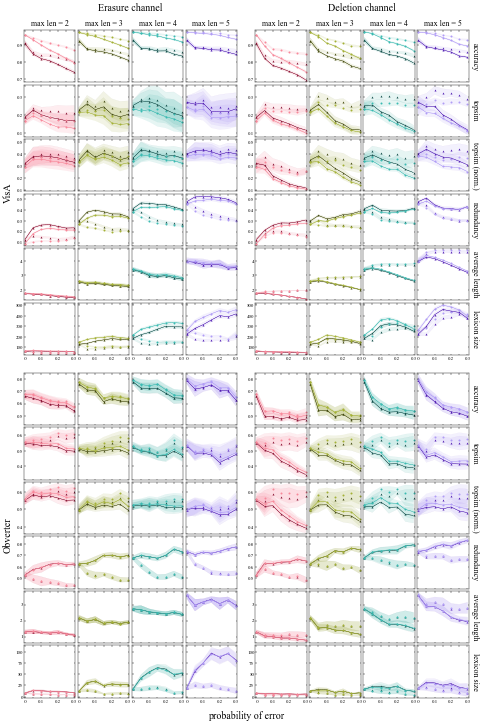

In [177]:
channels = ['erasure', 'deletion']
variables = [
    'accuracy', 'topsim', 'topsim_norm',
    'redundancy_act', 'average_length', 'unique_msg'
]
lengths = range(2, 6)

def plot(dfs):
    bright_colors, dark_colors = get_palette(len(lengths), 0.7, 0.3)
    err_bright, err_dark = get_palette(len(lengths), 0.65, 0.35)

    w, h = 15.7, 15.7 * 1.5
    fig = plt.figure(figsize=inches(w, h), dpi=72)
    subfigs = fig.subfigures(len(dfs), len(channels), wspace=4 / 72 * h / w, hspace=4 / 72)
    axes = {}

    for (c, channel), (d, df) in product(enumerate(channels), enumerate(dfs)):
        if d == 0:
            subfigs[d, c].suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.05, va='baseline')
        if c == 0:
            subfigs[d, c].supylabel('VisA' if d == 0 else 'Obverter', fontsize=10, ha='right', x=-0.05)
        subplots = subfigs[d, c].subplots(
            len(variables), len(lengths),
            gridspec_kw={
                'wspace': 2 / 72 * h / w, 'hspace': 2 / 72 * len(variables) / len(lengths),
                'top':1, 'bottom': 0, 'left': 0, 'right': 1,
            },
            sharex=True, sharey=False,
        )
            
        for v, variable in enumerate(variables):
            for l, length in enumerate(lengths):
                data = df[(df.channel == channel) & (df.max_len == length)]
                data = data.assign(noise_dataset=(data.dataset + ' ' + data.messages))
                data = data[['error_prob', 'noise_dataset', variable]]
                ax = axes[d, c, l, v] = subplots[v, l]

                lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
                sns.lineplot(
                    data=data,
                    x='error_prob', y=variable,
                    hue='noise_dataset', style='noise_dataset',
                    markers=('^', '^', 'o', 'o'), markeredgewidth=0,   
                    hue_order=('test received', 'test sent', 'train received', 'train sent'),
                    style_order=('test received', 'test sent', 'train received', 'train sent'),
                    palette=(dark_colors[l], dark_colors[l], bright_colors[l], bright_colors[l]),
                    dashes=[lines, dots, lines, dots],
                    errorbar=('se', 2), seed=42, ax=ax, legend=None, zorder=1.5,
                    err_kws={
                        'alpha': 0.12,
                        'facecolors': [err_bright[l], err_bright[l], err_dark[l], err_dark[l]],
                    },
                )
                
                ax.tick_params(
                    which='major',
                    labelbottom=(v + 1 == len(variables)),
                    labelleft=(l == 0), labeltop=False,
                    labelright=False, labelsize=5,
                )
                ax.tick_params(
                    which='minor',
                    labelbottom=False, labelleft=False,
                    labeltop=False, labelright=False,
                )
                ax.set_xticks(ticks=np.arange(0, 0.35, 0.10))
                ax.set_xticks(ticks=np.arange(0, 0.35, 0.05), minor=True)
                ax.tick_params(axis='y', pad=0.8)
                ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.1f}' if x > 0 else ' 0')

                if v == 0 and d == 0:
                    ax.set_xlabel(f'max len = {length}', visible=True, fontsize='medium')
                    ax.xaxis.set_label_position("top")
                else:
                    ax.set_xlabel(None)
                    
                if c == 1 and l + 1 == len(lengths):
                    ax.yaxis.set_label_position("right")
                    varname = (
                        variable
                        .replace('unique_msg', 'lexicon size')
                        .replace('redundancy_act', 'redundancy')
                        .replace('topsim_norm', 'topsim (norm.)')
                        .replace('_', ' ')
                        # .replace('length', 'len.')
                        # .replace('redundancy', 'redund.')
                    )
                    ax.set_ylabel(varname, rotation=270, fontsize='medium', visible=True, va='baseline')
                else:
                    ax.set_ylabel(None)
    if d == 1:
        fig.supxlabel('probability of error', fontsize=10, va='top', y=-0.02)
        
    # share y axes between subfigures for each metric
    # for v, _ in enumerate(variables[:-1]):
    #     axs = [ax for key, ax in axes.items() if key[-1] == v]
    #     for ax in axs[1:]:
    #         ax.sharey(axs[0])
    #     axs[0].autoscale(axis='y')

    # handle lexicon size
    # for d, _ in enumerate(dfs):
    for d, v in product(range(len(dfs)), range(len(variables))):
        axs = [ax for key, ax in axes.items() if key[0] == d and key[-1] == v]
        for ax in axs[1:]:
            ax.sharey(axs[0])
        axs[0].autoscale(axis='y')

    plt.show()

    fig.savefig(
        f'../figs/fig-main.pdf', format='pdf', dpi='figure',
        bbox_inches='tight', pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot([final_visa, final_img])

### Legend

line 5.6 0.0
line 5.6 0.0


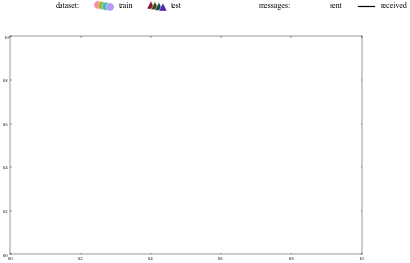

In [10]:
# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors, marker='o'):
        self.colors = colors
        self.marker = mmark.MarkerStyle(marker, fillstyle='full')
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        paths = [mmark.MarkerStyle(orig_handle.marker, fillstyle='full').get_path()] * len(orig_handle.colors)
        dpi = legend.figure.get_dpi()
        marker_size = (fontsize * 2)
        size = marker_size ** 2

        wd = min(width, marker_size * (len(paths) + 1) / 2)
        sep = wd / (len(paths))
        x0 = sep / 2
        yoffset = fontsize / 4 / (len(paths) - 1)
        y0 = marker_size / 4 + (fontsize - marker_size) / 4 + yoffset

        border_wd = plt.rcParams['lines.linewidth']

        artist = PathCollection(
            paths,
            sizes=[marker_size + border_wd for _ in paths],
            offsets = [(x0 + sep * i, y0 - i * yoffset) for i in range(len(paths))],
            facecolors=orig_handle.colors, linewidths=border_wd, edgecolors='white',
        )

        handlebox.add_artist(artist)

class LineHandler(HandlerLine2D):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        xdescent, ydescent, width, height = self.adjust_drawing_area(
            legend, orig_handle,
            handlebox.xdescent, handlebox.ydescent,
            handlebox.width, handlebox.height,
            fontsize,
        )
        ydescent += fontsize / 4
        artists = self.create_artists(
            legend, orig_handle, xdescent, ydescent,
            width, height, fontsize, handlebox.get_transform()
        )
        for a in artists:
            handlebox.add_artist(a)
        return artists[0]


def export_legend(n_colors, fs=None):
    bright_colors, dark_colors = get_palette(n_colors, l_bright, l_dark)

    placeholder = mpatches.Patch(alpha=0)
    fig, ax = plt.subplots(1, figsize=inches(16,10))
    fig.set_dpi(72)
    wd = 2 * plt.rcParams['lines.linewidth']
    
    handles, labels = ax.get_legend_handles_labels()
    handles.extend([
        placeholder,
        MulticolorPatch(bright_colors, 'o'),
        MulticolorPatch(dark_colors, '^'),
        placeholder,
        placeholder,
        mlines.Line2D([0],[0], color='black', linestyle=':', linewidth=1.5 * wd),
        mlines.Line2D([0],[0], color='black', linestyle='-', linewidth=1.5 * wd),
    ])
    labels.extend([
        'dataset:', 'train', 'test',
        '',
        'messages:', 'sent', 'received',
    ])

    fs = plt.rcParams['font.size'] if fs is None else fs
    legend = fig.legend(
        handles, labels, ncols=7, loc=1,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), mlines.Line2D: LineHandler()},
        borderaxespad=0., frameon=False, framealpha=1,
        borderpad=0.3, fontsize=fs,  # mode="expand", 
    )
    
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # print(bbox, legend.columnspacing, legend.handlelength)
    bp = legend.borderpad * fs / 72 # plt.rcParams['font.size'] / 72
    fig.savefig('legend0-sq.pdf', format='pdf', dpi='figure', bbox_inches=bbox)# backend='pdf')
    x0 = bbox.x0 + (legend.handletextpad + legend.handlelength) * fs / 72 # plt.rcParams['font.size'] / 72
    # x1 = bbox.x1 - x0 - 
    # print(bbox)
    
    bbox = mtransforms.Bbox.from_bounds(x0, bbox.y0, bbox.x1 - x0 + bp, bbox.y1 - bbox.y0)
    # bbox = mtransforms.Bbox.from_bounds(x0, bbox.y0, x1, bbox.y1 - bbox.y0)
    # print(bbox)
    # fig.savefig('legend.png', format='png', dpi='figure', bbox_inches=bbox)
    fig.savefig(f'../figs/legend-main-{n_colors}.pdf', format='pdf', dpi='figure', bbox_inches=bbox,  backend='pdf')

export_legend(4, None)

## Mutual information

### Fig (max length 5)

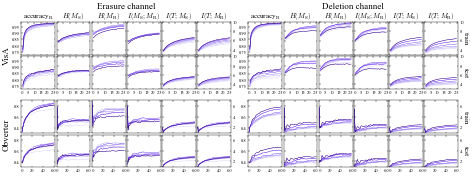

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


In [89]:
channels = ['erasure', 'deletion']
variables = (
    'accuracy_received',
    'entropy_sent',
    'entropy_received',
    'mutual_info_sent_received',
    'mutual_info_sent_target', 
    # 'mutual_info_sent_selected',
    'mutual_info_received_target',
    # 'mutual_info_received_selected',
)
max_len = 5
order = np.round(np.arange(0, 0.35, 0.05), decimals=3).tolist()[::-1]

    
def plot(dfs):
    # get palette & linestyles
    n_error_probs = 6
    palettes = [[(0, 0, 0)] for _ in range(len(variables))]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(4, h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    palette = palettes[(2, 3, 4, 5).index(max_len)]
    lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
    linestyles = [dots] + [lines] * n_error_probs
    
    fig = plt.figure(figsize=inches(15.4, 15.4 / 3), dpi=72)
    outer_subfigs = fig.subfigures(1, 2, wspace=6 / 72, hspace=0 / 72)
    axes = {}

    for c, channel in enumerate(channels):
        inner_subfigs = outer_subfigs[c].subfigures(2, 1, wspace=0 / 72, hspace=12 / 72)
        for d, df in enumerate(dfs):
            subplots = inner_subfigs[d].subplots(
                2, len(variables),
                sharex=False, sharey=False,
                gridspec_kw={
                    'hspace': 3 / 72, 'wspace': 3 / 72,
                    'top': 1, 'bottom': 0,
                    'left': 0, 'right': 1,
                },
            )

            if d == 0:
                inner_subfigs[d].suptitle(f'{channel} channel'.capitalize(), fontsize=9, y=1.20, va='baseline')
            if c == 0:
                inner_subfigs[d].supylabel('VisA' if d == 0 else 'Obverter', fontsize=9, ha='right', x=-0.05)
            else:
                inner_subfigs[d].text(s='train', rotation=270, fontsize=7, ha='left', va='center', x=1.025, y=0.75)
                inner_subfigs[d].text(s='test', rotation=270, fontsize=7, ha='left', va='center', x=1.025, y=0.25)

            for p, phase in enumerate(['train', 'test']):
                _data = df[(df.phase == phase) & (df.channel == channel) & (df.max_len == max_len)]
                _sent = _data[_data.messages == 'sent']
                _received = _data[_data.messages == 'received']
                data = pd.DataFrame({
                    'epoch': _sent.epoch.tolist(),
                    'error_prob': _sent.error_prob.tolist(),
                    'accuracy_received': _received.accuracy.tolist(),
                    'entropy_sent': _sent.entropy_msg.tolist(),
                    'entropy_received': _received.entropy_msg.tolist(),
                    'mutual_info_sent_received': _received.mutual_info_sent_received.tolist(),
                    'mutual_info_sent_target': _sent['mutual_info_msg_target'].tolist(),
                    'mutual_info_received_target': _received['mutual_info_msg_target'].tolist(),
                    'mutual_info_sent_selected': _sent['mutual_info_msg_selected'].tolist(),
                    'mutual_info_received_selected': _received['mutual_info_msg_selected'].tolist(),
                })
                for v, variable in enumerate(variables):
                    ax = axes[c, d, p, v] = subplots[p, v]

                    sns.lineplot(
                        data=data,
                        x='epoch', y=variable, hue='error_prob', style='error_prob',
                        hue_order=order, style_order=order,
                        palette=palette[::-1], dashes=linestyles[::-1],
                        ax=ax, legend=None, errorbar=None, zorder=1.5,
                    )
                    ax.tick_params(
                        which='major',
                        labelbottom=(p == 1),
                        labelleft=(v == 0),
                        labeltop=False,
                        labelright=(v == len(variables) - 1),
                        labelsize=4.5,
                    )

                    ticks = np.arange(0, data.epoch.max() + 1, 5 if d == 0 else 20)
                    ticklabels = [str(x) for x in ticks]
                    ticklabels[0], ticklabels[-1] = '  ' + ticklabels[0], ticklabels[-1] + ' '
                    ax.set_xlim(0, data.epoch.max() + 1 if d == 0 else data.epoch.max() + 2)
                    ax.set_xticks(ticks, labels=ticklabels)
                
                    if d == p == 0:
                        if variable == 'accuracy_received':
                            colname = 'accuracy$_\\mathrm{R}$'
                        elif variable == 'mutual_info_sent_received':
                            colname = '$I(M_\\mathrm{S}; M_\\mathrm{R})$'
                        elif variable == 'mutual_info_sent_target':
                            colname = '$I(T; M_\\mathrm{S})$'
                        elif variable == 'mutual_info_received_target':
                            colname = '$I(T; M_\\mathrm{R})$'
                        elif variable == 'mutual_info_sent_selected':
                            colname = '$I(T\'; M_\\mathrm{S})$'
                        elif variable == 'entropy_sent':
                            colname = '$H(M_\\mathrm{S})$'
                        elif variable == 'entropy_received':
                            colname = '$H(M_\\mathrm{R})$'
                        else:
                            colname = '$I(T\'; M_\\mathrm{R})$'
                        ax.set_xlabel(colname, visible=True, fontsize=7)
                        ax.xaxis.set_label_position("top")
                    else:
                        ax.set_xlabel(None)

                    ax.set_ylabel(None)
                    # if variable == variables[-1] and channel == channels[-1]:
                        # ax.yaxis.set_label_position("right")
                        # ax.set_ylabel(phase, rotation=270, fontsize='small', visible=True, va='baseline', labelpad=0)
                    # else:
                        # ax.set_ylabel(None)

    # share y axes between subfigures separately for accuracy and all other variables
    for ds in range(2):
        for group in ([0], range(1, 6)):
            axs = [ax for key, ax in axes.items() if key[-1] in group and key[1] == ds]
            for ax in axs[1:]:
                ax.sharey(axs[0])
            axs[0].autoscale(axis='y')
            axs[0].yaxis.set_major_locator(MaxNLocator(nbins=3, steps=[1, 2, 5], min_n_ticks=3, integer=True))

    plt.show()
    fig.savefig(
        f'../figs/fig-length{max_len}-mi.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot([history_visa, history_img])

#### Legend (TODO), change to max len 4?

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection

# define an object that will be used by the legend
class MulticolorEntry(object):
    def __init__(self, colors, linestyle='-'):
        self.colors = colors
        self.linestyle = linestyle
        
# define a handler for the MulticolorPatch object
class MulticolorEntryHandler(object):
    def __init__(self, margin=0.1):
        self.margin = margin
    
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        x0, y0 = handlebox.xdescent, handlebox.ydescent

        paths = []
        codes = [mpath.Path.MOVETO, mpath.Path.LINETO]
        if len(orig_handle.colors) == 1:
            y = y0 + 0.5 * height
            verts = [(x0, y), (x0 + width, y)]
            paths.append(mpath.Path(verts, codes))
        else:
            # y0 += self.margin
            yusable = height * (1 - 2 * self.margin)
            offset = yusable / (len(orig_handle.colors) - 1)
            for i in range(len(orig_handle.colors)):
                verts = [(x0, y0 + offset * i), (x0 + width, y0 + offset * i)]
                paths.append(mpath.Path(verts, codes))

        artist = PatchCollection(
            [mpatches.PathPatch(p) for p in paths],
            match_original=True,
            # facecolors=orig_handle.colors,
            # linestyles=orig_handle.linestyle,
            # linewidths=[2] * len(orig_handle.colors),
        )
        handlebox.add_artist(artist)
        return artist

class HandlerMulticolorLines(HandlerLineCollection):
    def create_artists(
        self, legend, orig_handle,
        xdescent, ydescent, width, height, fontsize, trans,
    ):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = mlines.Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[1] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


def export_legend(n_colors, fs=None):
    n_error_probs = 6
    palettes = [[] for _ in range(n_colors)]
    l_max, base = 0.9, 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    print(lightness)
    for l in lightness:
        colors = sns.husl_palette(n_colors, h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    palette = palettes[max_len]

    placeholder = mpatches.Patch(alpha=0)
    fig, ax = plt.subplots(1, figsize=inches(16,10))
    fig.set_dpi(72)
    wd = 2 * plt.rcParams['lines.linewidth']
    
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mlines.Line2D([0],[0], color='black', linestyle=':', linewidth=wd))
    handles.extend([
        LineCollection(n_colors * [[(0, 0)]], linestyles='-', colors=[p[i] for p in palettes], linewidths=wd)
        for i in range(len(palettes[0]))
    ])

    labels.extend([f'$p_e = {p:.2f}$' for p in np.arange(0, 0.35, 0.05, dtype=np.float64)])
    print(handles)

    fs = 8
    legend = fig.legend(
        handles, labels, ncols=7, loc=1,
        handler_map={LineCollection: HandlerMulticolorLines()},
        borderaxespad=0., frameon=False, framealpha=1,
        borderpad=0.2, fontsize=fs,  # mode="expand", 
        columnspacing=1.2,
        handletextpad=0.6,
    )
    
    fig  = legend.figure
    fig.canvas.draw()
    fig.axes[0].axis('off')
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bp = legend.borderpad * fs / 72 # plt.rcParams['font.size'] / 72
    x0 = bbox.x0 + (legend.handletextpad + legend.borderpad) * fs / 72 # plt.rcParams['font.size'] / 72
    y0 = bbox.y0 + 6 / 72
    bbox = mtransforms.Bbox.from_bounds(x0, y0, bbox.x1 - x0 + bp, bbox.y1 - y0)

    fig.savefig(f'../figs/legend-entropy-{n_colors}.pdf', format='pdf', dpi='figure', bbox_inches=bbox,  backend='pdf')

export_legend(4, None)

### Fig (all lengths)

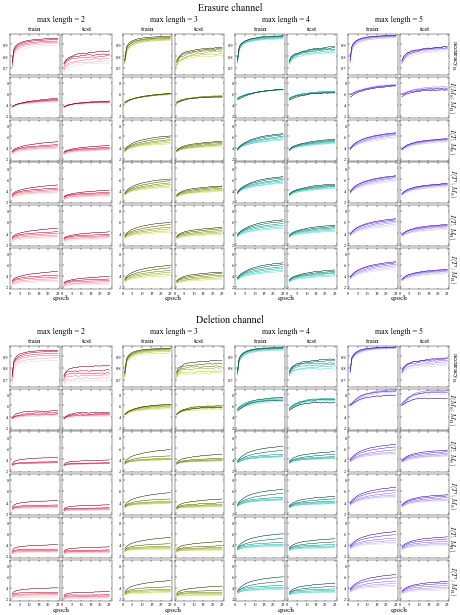

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


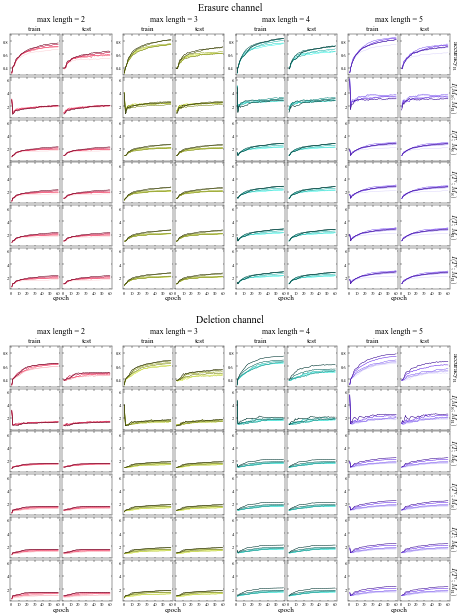

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


In [84]:
channels = ['erasure', 'deletion']
variables = (
    'accuracy_received',
    'mutual_info_sent_received',
    'mutual_info_sent_target', 
    'mutual_info_sent_selected',
    'mutual_info_received_target',
    'mutual_info_received_selected',
)
lengths = range(2, 6)
order = np.round(np.arange(0, 0.35, 0.05), decimals=3).tolist()[::-1]

    
def plot(df, fname):
    # get palette & linestyles
    n_error_probs, n_hues = 6, len(lengths)
    palettes = [[(0, 0, 0)] for _ in range(n_hues)]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(n_hues, h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
    linestyles = [dots] + [lines] * n_error_probs

    # create fig and storage objects for axes
    fig = plt.figure(figsize=inches(15.5, 20), dpi=72)
    outer_subfigs = fig.subfigures(2, 1, wspace=0 / 72, hspace=16 / 72)
    axes = {}

    for c, channel in enumerate(channels):        
        inner_subfigs = outer_subfigs[c].subfigures(1, 4, wspace=8/72)
        outer_subfigs[c].suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.125, x=0.5, ha='center')
        # outer_subfigs[c].supxlabel('epoch', fontsize=7, y=-0.02, va='top')

        for l, length in enumerate(lengths):
            subplots = inner_subfigs[l].subplots(
                len(variables), 2,
                sharex=False, sharey=False,
                gridspec_kw={
                    'hspace': 3 / 72, 'wspace': 3/ 72,
                    'top': 1, 'bottom': 0,
                    'left': 0, 'right': 1,
                },
            )
            # inner_subfigs[l].supxlabel(f'max len = {length}', fontsize=8, x=0.5, y=1.04, ha='center')
            inner_subfigs[l].suptitle(f'max length = {length}', fontsize=8, x=0.5, y=1.05, ha='center', va='baseline')
            inner_subfigs[l].supxlabel('epoch', fontsize=7, y=-0.02, va='top')

            for p, phase in enumerate(['train', 'test']):
                _data = df[(df.phase == phase) & (df.channel == channel) & (df.max_len == length)]
                _sent = _data[_data.messages == 'sent']
                _received = _data[_data.messages == 'received']
                data = pd.DataFrame({
                    'epoch': _sent.epoch.tolist(),
                    'error_prob': _sent.error_prob.tolist(),
                    'accuracy_received': _received.accuracy.tolist(),
                    'mutual_info_sent_received': _received.mutual_info_sent_received.tolist(),
                    'mutual_info_sent_target': _sent['mutual_info_msg_target'].tolist(),
                    'mutual_info_received_target': _received['mutual_info_msg_target'].tolist(),
                    'mutual_info_sent_selected': _sent['mutual_info_msg_selected'].tolist(),
                    'mutual_info_received_selected': _received['mutual_info_msg_selected'].tolist(),
                })
                for v, variable in enumerate(variables):
                    axes[c, l, p, v] = ax = subplots[v, p]
                    sns.lineplot(
                        data=data,
                        x='epoch', y=variable,
                        hue='error_prob', style='error_prob',
                        hue_order=order, style_order=order,
                        palette=palettes[l][::-1],
                        dashes=linestyles[::-1],
                        ax=ax, legend=None, errorbar=None, zorder=1.5,
                    )
                    ax.tick_params(
                        which='major',
                        labelleft=(p == 0),
                        labeltop=False,
                        labelright=False,
                        labelbottom=(v + 1 == len(variables)),
                        labelsize=4.5,
                    )
                    if fname.lower() == 'visa':
                        ax.set_xlim(0, data.epoch.max() + 1)
                        ax.set_xticks(np.arange(0, data.epoch.max() + 1, 5))
                    else:
                        ax.set_xticks(np.arange(0, data.epoch.max() + 2, 10))
                        ax.set_xlim(-1, data.epoch.max() + 2)
                    
                    if v == 0:
                        ax.set_xlabel(phase, fontsize=7, y=1.01, va='baseline')
                        ax.xaxis.set_label_position("top")
                    # elif v + 1 == len(variables):
                        # ax.set_xlabel('epoch', fontsize=7, ha='center', x=0.5, y=-0.03)
                    else:
                        ax.set_xlabel(None)

                    if p == 1 and l + 1 == len(lengths):
                        if variable == 'accuracy_received':
                            varname = 'accuracy$_\\mathrm{R}$'
                        elif variable == 'mutual_info_sent_received':
                            varname = '$I(M_\\mathrm{S}; M_\\mathrm{R})$'
                        elif variable == 'mutual_info_sent_target':
                            varname = '$I(T; M_\\mathrm{S})$'
                        elif variable == 'mutual_info_received_target':
                            varname = '$I(T; M_\\mathrm{R})$'
                        elif variable == 'mutual_info_sent_selected':
                            varname = '$I(T\'; M_\\mathrm{S})$'
                        else:
                            varname = '$I(T\'; M_\\mathrm{R})$'
                        ax.set_ylabel(varname, fontsize=7, rotation=270, labelpad=8)
                        ax.yaxis.set_label_position('right')
                    else:
                        ax.set_ylabel(None)

    # share y axes between subfigures for each variable
    # grouped: accuracy, all other variables
    for group in [(0,), range(1, 6)]:
        axs = [ax for key, ax in axes.items() if key[-1] in group]
        for ax in axs[1:]:
            ax.sharey(axs[0])
        axs[0].autoscale(axis='y')
        
        # ax.yaxis.set_major_locator(MultipleLocator(base=0.05, offset=0.0))
        # if var == 'redundancy':
        # ax.yaxis.set_major_locator(MaxNLocator(4, steps=[1, 2, 5], prune='both'))
        # ax.autoscale(axis='y')

    plt.show()
    fig.savefig(
        f'../figs/fig-mi-all-{fname}.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.2 / 72)
    close_plot(fig)

plot(history_visa, 'visa')
plot(history_img, 'obverter')

#### Legend

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


[0.24973819 0.43489653 0.58210387 0.704302   0.80876723 0.9       ]
[<matplotlib.lines.Line2D object at 0x7f912d7bb070>, <matplotlib.collections.LineCollection object at 0x7f912b9cc850>, <matplotlib.collections.LineCollection object at 0x7f912b9cc220>, <matplotlib.collections.LineCollection object at 0x7f912b9cc2b0>, <matplotlib.collections.LineCollection object at 0x7f912ce9ea30>, <matplotlib.collections.LineCollection object at 0x7f912ce9eca0>, <matplotlib.collections.LineCollection object at 0x7f912c6c80a0>]


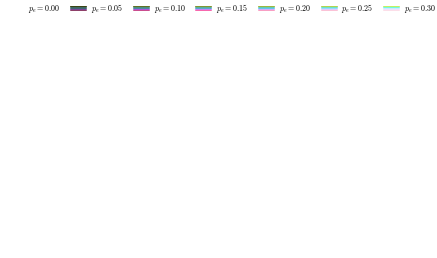

In [12]:
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection

# define an object that will be used by the legend
class MulticolorEntry(object):
    def __init__(self, colors, linestyle='-'):
        self.colors = colors
        self.linestyle = linestyle
        
# define a handler for the MulticolorPatch object
class MulticolorEntryHandler(object):
    def __init__(self, margin=0.1):
        self.margin = margin
    
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        x0, y0 = handlebox.xdescent, handlebox.ydescent

        paths = []
        codes = [mpath.Path.MOVETO, mpath.Path.LINETO]
        if len(orig_handle.colors) == 1:
            y = y0 + 0.5 * height
            verts = [(x0, y), (x0 + width, y)]
            paths.append(mpath.Path(verts, codes))
        else:
            # y0 += self.margin
            yusable = height * (1 - 2 * self.margin)
            offset = yusable / (len(orig_handle.colors) - 1)
            for i in range(len(orig_handle.colors)):
                verts = [(x0, y0 + offset * i), (x0 + width, y0 + offset * i)]
                paths.append(mpath.Path(verts, codes))

        artist = PatchCollection(
            [mpatches.PathPatch(p) for p in paths],
            match_original=True,
            # facecolors=orig_handle.colors,
            # linestyles=orig_handle.linestyle,
            # linewidths=[2] * len(orig_handle.colors),
        )
        handlebox.add_artist(artist)
        return artist

class HandlerMulticolorLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = mlines.Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[1] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


def export_legend(n_colors, fs=None):
    n_error_probs = 6
    palettes = [[] for _ in range(n_colors)]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    print(lightness)
    for l in lightness:
        colors = sns.husl_palette(n_colors, h=0.01 + 1 / 8, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)

    placeholder = mpatches.Patch(alpha=0)
    fig, ax = plt.subplots(1, figsize=inches(16,10))
    fig.set_dpi(72)
    wd = 2 * plt.rcParams['lines.linewidth']
    
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mlines.Line2D([0],[0], color='black', linestyle=':', linewidth=wd))
    handles.extend([
        LineCollection(n_colors * [[(0, 0)]], linestyles='-', colors=[p[i] for p in palettes], linewidths=wd)
        for i in range(len(palettes[0]))
    ])

    labels.extend([f'$p_e = {p:.2f}$' for p in np.arange(0, 0.35, 0.05, dtype=np.float64)])
    print(handles)

    fs = 8
    legend = fig.legend(
        handles, labels, ncols=7, loc=1,
        handler_map={LineCollection: HandlerMulticolorLines()},
        borderaxespad=0., frameon=False, framealpha=1,
        borderpad=0.2, fontsize=fs,  # mode="expand", 
        columnspacing=1.2,
        handletextpad=0.6,
    )
    
    fig  = legend.figure
    fig.canvas.draw()
    fig.axes[0].axis('off')
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bp = legend.borderpad * fs / 72 # plt.rcParams['font.size'] / 72
    x0 = bbox.x0 + (legend.handletextpad + legend.borderpad) * fs / 72 # plt.rcParams['font.size'] / 72
    y0 = bbox.y0 + 6 / 72
    bbox = mtransforms.Bbox.from_bounds(x0, y0, bbox.x1 - x0 + bp, bbox.y1 - y0)

    fig.savefig(f'../figs/legend-mi-{n_colors}.pdf', format='pdf', dpi='figure', bbox_inches=bbox,  backend='pdf')

export_legend(6, None)

## KLD (the other direction TODO, check if everything is up to date)

### Fig

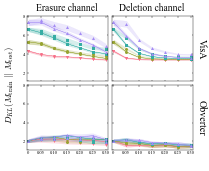

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


In [187]:
channels = ['erasure', 'deletion']


def plot_kld(df, lengths, settings, dataset='train'):
    palette = sns.husl_palette(len(lengths))
    fig = plt.figure(figsize=inches(6, 6), dpi=72)
    subfigs = fig.subfigures(1, len(channels), wspace=0, hspace=0)
    lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']

    channel_axes = {}
    for c, channel in enumerate(channels):
        subfig = subfigs[c]
        subfig.suptitle(f'{channel} channel'.capitalize(), fontsize='large')
        channel_axes[channel] = subfig.subplots(
            len(settings), 1,
            gridspec_kw={'wspace': 2 / 72, 'hspace': 4 / 72},
            sharex='row', sharey=False,
        )

        for s, setting in enumerate(settings):
            data = df[(df.dataset == dataset) & (df.channel == channel) & (df.setting == setting)]
            data = pd.DataFrame({
                    'max_len': data.max_len.tolist(),
                    'messages': data.messages.tolist(),
                    'max_len_msg': (data.max_len.astype(str) + '_' + data.messages).tolist(),
                    'error_prob': data.error_prob.tolist(),
                    'kld': data.kld_train_test.tolist(),
            })
            # data = data[data.messages != 'sent']  # missing data...
            # print(data[data.messages == 'received'])
            # print(data.max_len_msg.unique())
            ax = channel_axes[channel][s]
            # order = np.round(np.arange(0, 0.35, 0.05), decimals=3).tolist()[::-1]
            sns.lineplot(
                data=data,
                x='error_prob', y='kld',
                hue='max_len', style='max_len_msg',
                # dashes=[()],
                markers=('v', 'v', 'o', 'o', 's', 's', '^', '^'),
                markeredgewidth=0,
                markersize=3,
                dashes=[dots, lines] * len(lengths),
                style_order=(
                    '2_sent', '2_received',
                    '3_sent', '3_received',
                    '4_sent', '4_received',
                    '5_sent', '5_received',
                ),
                hue_order=lengths,
                palette=palette,
                ax=ax, 
                legend=None, 
                errorbar=('ci', 95),
                zorder=1.5)
            ax.tick_params(
                which='major',
                labelbottom=(s > 0),
                labelleft=(c == 0),
                labeltop=False,
                labelright=False)

            ax.set_xticks(np.arange(0, 0.35, 0.05))
            ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.2f}' if x > 0 else '0')
            ax.set_xlabel(None)
            if channel == channels[-1]:
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(setting, rotation=270, fontsize=10, visible=True, va='baseline', labelpad=6)#, va='bottom')#, labelpad=22)
            else:
                ax.set_ylabel(None)

    # share y axes between subfigures for each metric
    axs = [ax for subfig in subfigs for ax in subfig.axes]
    for ax in axs[1:]:
        ax.sharey(axs[0])
    ax.autoscale(axis='y')
    fig.supylabel('$D_{KL}(M_\mathrm{train} \ || \ M_\mathrm{test})$',fontsize=9, ha='right', x=-0.05)#, va='baseline')
    fig.supxlabel('probability of error', fontsize=10, va='baseline', y=0.02)
    # add padding
    top_padding = inches(0.6)
    bottom_padding = inches(0.7)
    sides_padding = 4 / 72#inches(0.1)
    w, h = fig.get_size_inches()
    b, t = bottom_padding / h, 1 - top_padding / h
    l, r = sides_padding / w, 1 - sides_padding / w
    fig.subplots_adjust(top=t, bottom=b, left=l, right=r)
    plt.show()
    fig.savefig(
        f'../figs/fig-kld.pdf', format='pdf', dpi='figure',
        # backend='pgf',
        # pad_inches=0.5,
        bbox_inches='tight',
        pad_inches=0)
    close_plot(fig)

final = pd.concat([
    final_visa.assign(setting='VisA'),
    final_img.assign(setting='Obverter'),
], ignore_index=True)
plot_kld(final, [2, 3, 4, 5], ['VisA', 'Obverter'])

### Legend

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


line 4.8999999999999995 0.0
line 4.8999999999999995 0.0
line 4.8999999999999995 0.0
line 4.8999999999999995 0.0
line 4.8999999999999995 0.0
line 4.8999999999999995 0.0


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


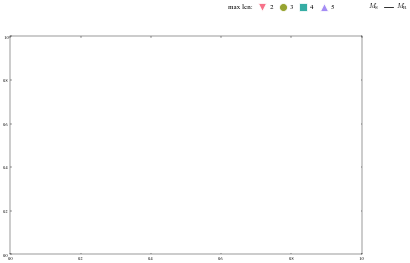

In [14]:
# define an object that will be used by the legend
class SinglecolorPatch(object):
    def __init__(self, colors, marker='o'):
        self.colors = colors
        self.marker = mmark.MarkerStyle(marker, fillstyle='full')

class UnsizedMarker(mmark.MarkerStyle):
    def _set_custom_marker(self, path):
        self._transform = transforms.IdentityTransform()
        self._path = path
        
# define a handler for the MulticolorPatch object
class SinglecolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        paths = [mmark.MarkerStyle(orig_handle.marker, fillstyle='full').get_path()] * len(orig_handle.colors)
        # orig_size = paths[0].get_sizes()
        # print(orig_size)
        um = UnsizedMarker(paths[0])
        dpi = legend.figure.get_dpi()
        marker_size = (fontsize * 2)
        size = marker_size ** 2
        # print('s, ms', size, marker_size, dpi, paths[0])
        # print(width, height, handlebox.xdescent, handlebox.ydescent)


        wd = min(width, marker_size * (len(paths) + 1) / 2)
        sep = wd / (len(paths))
        x0 = marker_size / 2  #size / 2#(width - wd + size) / 2
        x0 = sep / 2  # y = marker_size / 4 + (plt.rcParams['font.size'] - marker_size) / 4
        yoffset = fontsize / 8
        y0 = marker_size / 4 + (fontsize - marker_size) / 4 + yoffset  # y = marker_size / 4

        border_wd = plt.rcParams['lines.linewidth']

        # print(width, wd, sep, x0)  print([x0 + sep * i for i in range(len(paths))])
        #artist = LineCollection(
        #    paths,
        #    sizes=[marker_size + border_wd for _ in paths],
        #    offsets = [(x0 + sep * i, y0 - i * yoffset) for i in range(len(paths))],
        #    facecolors=orig_handle.colors, linewidths=border_wd, edgecolors='white',
        #    # linewidths=[lw] * len(paths),
        #)
        artist = [mlines.Line2D([], [], color='blue', marker='*', linestyle='None',
                          markersize=10, label='Blue stars')]
        #artist = LineCollection(
        #    #[Line2D([0], [0], markersize=marker_size, marker=um)],
        #    [ax.scatter(0, 0, marker=m1, s=(marker_size + border_wd)) for c in orig_handle.colors],
        #    #sizes=[marker_size + border_wd for _ in paths],
        #    offsets = [(x0 + sep * i, y0 - i * yoffset) for i in range(len(paths))],
        #    facecolors=orig_handle.colors, linewidths=border_wd, edgecolors='white',
        #    # linewidths=[lw] * len(paths),
        #)
        #artist = Line2D(
        #    [x0 + sep * i for i in range(len(paths))],
        #    [y0 - i * yoffset for i in range(len(paths))],
        #    s=size,
        #)
       # artist = LineCollection(
       #     [Line2D([0], [0], marker=orig_handle.marker, color=None, markerfacecolor='g', markersize=marker_size)
       #      for c in orig_handle.colors],
       #     # [ax.scatter(0, 0, marker=m1, s=(marker_size + border_wd)],
       #     offsets = [(x0 + sep * i, y0 - i * yoffset) for i in range(len(paths))],
       #     facecolors=orig_handle.colors, linewidths=border_wd, edgecolors='white',  
       #     linewidths=border_wd, edgecolors='white'
       # )Line2D([0], [0], marker='o', color='w', label='Scatter',
       #                   markerfacecolor='g', markersize=15)

        
        handlebox.add_artist(artist)

class LineHandler(HandlerLine2D):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        xdescent, ydescent, width, height = self.adjust_drawing_area(
            legend, orig_handle,
            handlebox.xdescent, handlebox.ydescent,
            handlebox.width, handlebox.height,
            fontsize,
        )
        ydescent += fontsize / 4  # height -= fontsize / 2
        artists = self.create_artists(
            legend, orig_handle, xdescent, ydescent,
            width, height, fontsize, handlebox.get_transform()
        )
        for a in artists:
            handlebox.add_artist(a)
        print('line', handlebox.height, handlebox.ydescent)

        return artists[0]


def get_handle(color, marker, fontsize):
    return mlines.Line2D([], [], color=color, marker=marker, linestyle='None',
                          markersize=(fontsize), markeredgewidth=plt.rcParams['lines.linewidth']*2, markeredgecolor='white',)
def export_legend(n_colors, fs=None):
    bright_colors, dark_colors = get_palette(n_colors, l_bright, l_dark)
    palette = sns.husl_palette(n_colors)
    placeholder = mpatches.Patch(alpha=0)
    fig, ax = plt.subplots(1, figsize=inches(16,10))
    fig.set_dpi(72)
    wd = 2 * plt.rcParams['lines.linewidth']
    fs = plt.rcParams['font.size'] if fs is None else fs

    handles, labels = ax.get_legend_handles_labels()
    handles.extend([
        placeholder,
        get_handle(palette[0], 'v', fs),
        get_handle(palette[1], 'o', fs),
        get_handle(palette[2], 's', fs),
        get_handle(palette[3], '^', fs),
        #mlines.Line2D([], [], color=p, marker='*', linestyle='None',
        #                  markersize=10, label='Blue stars')
        #MulticolorPatch([palette[0]], 'v'),
        #MulticolorPatch([palette[1]], 'o'),
        #MulticolorPatch([palette[2]], '^'),
        placeholder,
        # placeholder,
        # SinglecolorPatch(palette[0], 'v'),
        # SinglecolorPatch(palette[1], '0'),
        # SinglecolorPatch(palette[2], '^'),
        # placeholder,
        # placeholder,
        # mlines.Line2D([0],[0], color=palette[0], linestyle=':', linewidth=1.5 * wd),
        # mlines.Line2D([0],[0], color=palette[1], linestyle='-', linewidth=1.5 * wd),
        mlines.Line2D([0],[0], linestyle=':', color='black', linewidth=1 * wd),
        mlines.Line2D([0],[0], linestyle='-', color='black', linewidth=1 * wd),
    ])
    labels.extend([
        # 'dataset:', 'train', 'test',
        #'',
        'max len:', '2', '3', '4', '5', #sent', 'received',
        '',
        # 'messages:',
        '$M_\mathrm{S}$', '$M_\mathrm{R}$',
    ])

    legend = fig.legend(
        handles, labels, ncols=8, loc=1,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), mlines.Line2D: LineHandler()},
        borderaxespad=0., frameon=False, framealpha=1,
        borderpad=0.3, fontsize=7,  # mode="expand", 
        labelspacing=0.0, handletextpad=0.4,
        handlelength=1.2, columnspacing=0.8,
    )
    
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # print(bbox, legend.columnspacing, legend.handlelength)
    bp = legend.borderpad * fs / 72 # plt.rcParams['font.size'] / 72
    fig.savefig('../figs/kld-legend.pdf', format='pdf', dpi='figure', bbox_inches=bbox)# backend='pdf')
    x0 = bbox.x0 + (legend.handletextpad + legend.handlelength) * fs / 72 # plt.rcParams['font.size'] / 72
    # x1 = bbox.x1 - x0 - 
    # print(bbox)
    
    bbox = mtransforms.Bbox.from_bounds(x0, bbox.y0, bbox.x1 - x0 + bp, bbox.y1 - bbox.y0)
    # bbox = mtransforms.Bbox.from_bounds(x0, bbox.y0, x1, bbox.y1 - bbox.y0)
    # print(bbox)
    # fig.savefig('legend.png', format='png', dpi='figure', bbox_inches=bbox)
    fig.savefig(f'legend-{n_colors}-kld.pdf', format='pdf', dpi='figure', bbox_inches=bbox,  backend='pdf')

export_legend(4, None)
# export_legend(4, 11)

## Training accuracy, redundancy, topsim

### Fig (v2) (TODO)

NameError: name 'df' is not defined

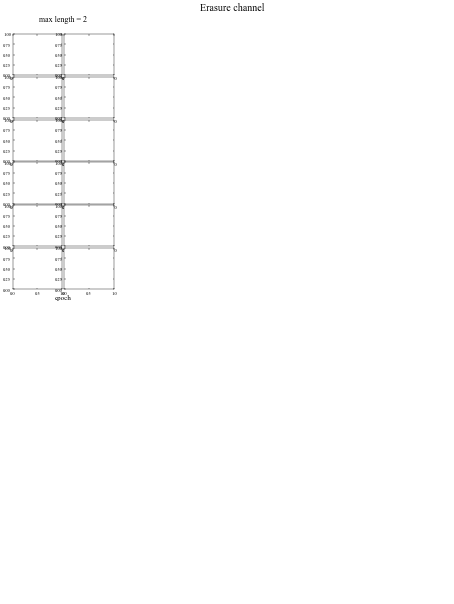

In [190]:
channels = ['erasure', 'deletion']
variables = (
    'accuracy_received',
    'mutual_info_sent_received',
    'mutual_info_sent_target', 
    'mutual_info_sent_selected',
    'mutual_info_received_target',
    'mutual_info_received_selected',
)
lengths = range(2, 6)
order = np.round(np.arange(0, 0.35, 0.05), decimals=3).tolist()[::-1]

    
def plot(dfs, phase):
    # get palette & linestyles
    n_error_probs, n_hues = 6, len(lengths)
    palettes = [[(0, 0, 0)] for _ in range(n_hues)]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(n_hues, h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
    linestyles = [dots] + [lines] * n_error_probs

    # create fig and storage objects for axes
    fig = plt.figure(figsize=inches(15.5, 20), dpi=72)
    outer_subfigs = fig.subfigures(2, 1, wspace=0 / 72, hspace=16 / 72)
    axes = {}

    for c, channel in enumerate(channels):        
        inner_subfigs = outer_subfigs[c].subfigures(1, 4, wspace=8/72)
        outer_subfigs[c].suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.125, x=0.5, ha='center')
        # outer_subfigs[c].supxlabel('epoch', fontsize=7, y=-0.02, va='top')

        for l, length in enumerate(lengths):
            subplots = inner_subfigs[l].subplots(
                len(variables), 2,
                sharex=False, sharey=False,
                gridspec_kw={
                    'hspace': 3 / 72, 'wspace': 3/ 72,
                    'top': 1, 'bottom': 0,
                    'left': 0, 'right': 1,
                },
            )
            # inner_subfigs[l].supxlabel(f'max len = {length}', fontsize=8, x=0.5, y=1.04, ha='center')
            inner_subfigs[l].suptitle(f'max length = {length}', fontsize=8, x=0.5, y=1.05, ha='center', va='baseline')
            inner_subfigs[l].supxlabel('epoch', fontsize=7, y=-0.02, va='top')

            for p, phase in enumerate(['train', 'test']):
                _data = df[(df.phase == phase) & (df.channel == channel) & (df.max_len == length)]
                _sent = _data[_data.messages == 'sent']
                _received = _data[_data.messages == 'received']
                data = pd.DataFrame({
                    'epoch': _sent.epoch.tolist(),
                    'error_prob': _sent.error_prob.tolist(),
                    'accuracy_received': _received.accuracy.tolist(),
                    'mutual_info_sent_received': _received.mutual_info_sent_received.tolist(),
                    'mutual_info_sent_target': _sent['mutual_info_msg_target'].tolist(),
                    'mutual_info_received_target': _received['mutual_info_msg_target'].tolist(),
                    'mutual_info_sent_selected': _sent['mutual_info_msg_selected'].tolist(),
                    'mutual_info_received_selected': _received['mutual_info_msg_selected'].tolist(),
                })
                for v, variable in enumerate(variables):
                    axes[c, l, p, v] = ax = subplots[v, p]
                    sns.lineplot(
                        data=data,
                        x='epoch', y=variable,
                        hue='error_prob', style='error_prob',
                        hue_order=order, style_order=order,
                        palette=palettes[l][::-1],
                        dashes=linestyles[::-1],
                        ax=ax, legend=None, errorbar=None, zorder=1.5,
                    )
                    ax.tick_params(
                        which='major',
                        labelleft=(p == 0),
                        labeltop=False,
                        labelright=False,
                        labelbottom=(v + 1 == len(variables)),
                        labelsize=4.5,
                    )
                    if fname.lower() == 'visa':
                        ax.set_xlim(0, data.epoch.max() + 1)
                        ax.set_xticks(np.arange(0, data.epoch.max() + 1, 5))
                    else:
                        ax.set_xticks(np.arange(0, data.epoch.max() + 2, 10))
                        ax.set_xlim(-1, data.epoch.max() + 2)
                    
                    if v == 0:
                        ax.set_xlabel(phase, fontsize=7, y=1.01, va='baseline')
                        ax.xaxis.set_label_position("top")
                    # elif v + 1 == len(variables):
                        # ax.set_xlabel('epoch', fontsize=7, ha='center', x=0.5, y=-0.03)
                    else:
                        ax.set_xlabel(None)

                    if p == 1 and l + 1 == len(lengths):
                        if variable == 'accuracy_received':
                            varname = 'accuracy$_\\mathrm{R}$'
                        elif variable == 'mutual_info_sent_received':
                            varname = '$I(M_\\mathrm{S}; M_\\mathrm{R})$'
                        elif variable == 'mutual_info_sent_target':
                            varname = '$I(T; M_\\mathrm{S})$'
                        elif variable == 'mutual_info_received_target':
                            varname = '$I(T; M_\\mathrm{R})$'
                        elif variable == 'mutual_info_sent_selected':
                            varname = '$I(T\'; M_\\mathrm{S})$'
                        else:
                            varname = '$I(T\'; M_\\mathrm{R})$'
                        ax.set_ylabel(varname, fontsize=7, rotation=270, labelpad=8)
                        ax.yaxis.set_label_position('right')
                    else:
                        ax.set_ylabel(None)

    # share y axes between subfigures for each variable
    # grouped: accuracy, all other variables
    for group in [(0,), range(1, 6)]:
        axs = [ax for key, ax in axes.items() if key[-1] in group]
        for ax in axs[1:]:
            ax.sharey(axs[0])
        axs[0].autoscale(axis='y')

    plt.show()
    fig.savefig(
        f'../figs/fig-mi-all-{phase}-2.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.2 / 72)
    close_plot(fig)

for phase in ('train', 'test'):
    plot([history_visa, history_img], phase)
    gc.collect()

# plot(history_visa, 'visa')
# plot(history_img, 'obverter')

### Fig

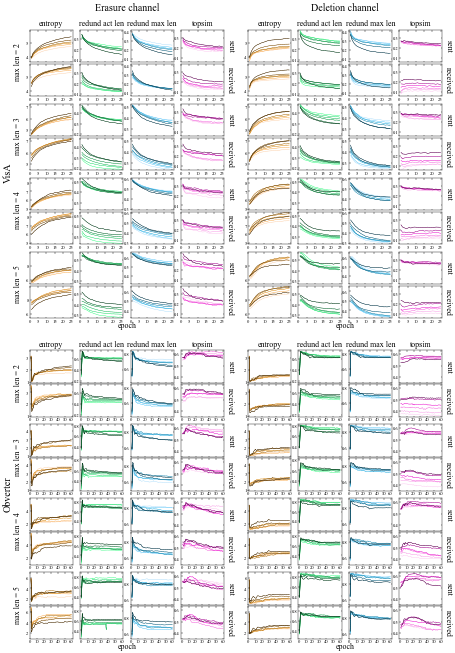

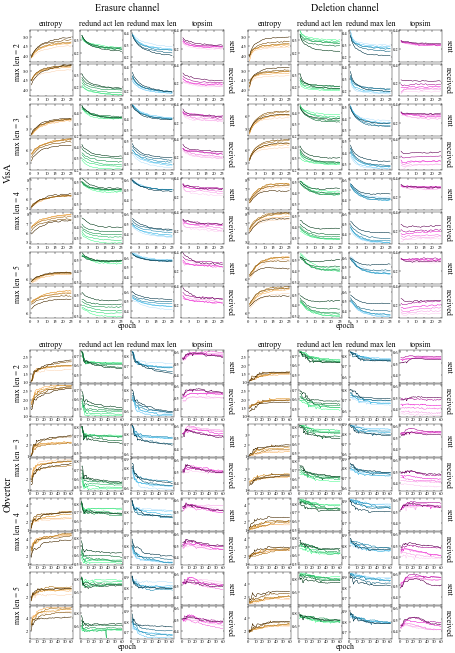

In [6]:
channels = ['erasure', 'deletion']
variables = ['entropy', 'redund act len', 'redund max len', 'topsim']
    
def plot_entropy(dfs, lengths, phase):
    # df = df[df.phase == phase].copy()

    # get palette & linestyles
    n_error_probs, n_hues = 6, len(lengths)
    palettes = [[(0, 0, 0)] for _ in range(n_hues)]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(n_hues, h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
    linestyles = [dots] + [lines] * n_error_probs

    # create fig and storage objects for axes
    fig = plt.figure(figsize=inches(15.7, 21.75), dpi=72)
    subfigs = fig.subfigures(2, 2, wspace=8 / 72, hspace=6 / 72)
    outer_axes = {}
    inner_axes = defaultdict(lambda: defaultdict(dict))

    for c, channel in enumerate(channels):
        padding = inches(1.2)
        w, h = fig.get_size_inches()
        if c == 0:
            left, right = padding / w, 1
            center = 0.5 + padding / 2 / w
        else:
            left, right = 0, 1 - padding / w
            center = 0.5 - padding / 2 / w
        # center = (r - l) / 2
        # l, r = padding / w, 1 - padding / w
        top = 1 - inches(0.75) / h
        
        for d, (dataset, df) in enumerate(zip(['VisA', 'Obverter'], dfs)):
            subfig = subfigs[d, c]
            # subfig.set_facecolor((str(1-0.1*(c+1)), 0.5))

            if d == 0:
                subfig.suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.075, x=center)
            # else:
            subfig.supxlabel('epoch', fontsize=8, x=center, y=-0.03)
            if c == 0:
                subfig.supylabel(dataset, fontsize=10, x=-0.05)

            outer_axes[(c, d)] = subfig.subfigures(
                len(lengths), 1, hspace=0,)

            data = df[(df.channel == channel) & (df.phase == phase)]
            data = pd.DataFrame({
                'max_len': data.max_len.tolist(),
                'epoch': data.epoch.tolist(),
                'error_prob': data.error_prob.tolist(),
                'messages': data.messages.tolist(),
                'entropy': data.entropy_msg.tolist(),
                'topsim': data.topsim.tolist(),
                'redund act len': data.redundancy_act.tolist(),
                'redund max len': data.redundancy_max.tolist(),
            })
            gc.collect()
            order = np.round(np.arange(0, 0.35, 0.05), decimals=3).tolist()[::-1]

            for l, length in enumerate(lengths):
                if c == 0:
                    outer_axes[(c, d)][l].supylabel(f'max len = {length}', fontsize=8, x=0.00)
                # padding = 36 / 72
                # w, h = fig.get_size_inches()
                # if c == 0:
                #     l, r = padding / w, 1
                # else:
                #     l, r = 0, 1 - padding / w
                # c = (r - l) / 2
                # l, r = padding / w, 1 - padding / w
                # t = 1 - inches(0.75) / h
                inner_axes[(c, d)][l] = outer_axes[(c, d)][l].subplots(
                    2, len(variables),
                    gridspec_kw={
                        'wspace': 12 / 72, 'hspace': 4 / 72,
                        'left': left, 'right': right
                    },
                )

                for m, messages in enumerate(['sent', 'received']):
                    _data = data[(data.max_len == length) & (data.messages == messages)]
                    for v, var in enumerate(variables):
                        ax = inner_axes[(c, d)][l][m, v]
                        sns.lineplot(
                            data=_data[['epoch', 'error_prob', var, 'max_len']],
                            x='epoch', y=var,
                            hue='error_prob', style='error_prob',
                            hue_order=order, style_order=order,
                            palette=palettes[l][::-1],
                            dashes=linestyles[::-1],
                            ax=ax, legend=None, errorbar=None, zorder=1.5)
                        ax.tick_params(
                            which='major',
                            labelleft=True,#(m == 0),  # (m == c == 0),
                            # labelright=(m == c == 1),
                            labelbottom=(m == 1),  # (l == 2 and m == 1),
                            pad=1)

                        if d == 0:
                            ax.set_xlim(0, _data.epoch.max() + 1)
                            ax.set_xticks(np.arange(0, _data.epoch.max() + 1, 5))
                        else:
                            ax.set_xticks(np.arange(0, _data.epoch.max() + 2, 10))
                            ax.set_xlim(-1, _data.epoch.max() + 2)
                        ax.set_ylabel(None)
                        ax.set_xlabel(None)

                        if l == m == 0 :
                            ax.xaxis.set_label_position("top")
                            ax.set_xlabel(var, fontsize=8, visible=True)
                        if v == 3:
                            ax.yaxis.set_label_position('right')
                            formatted = '$M_\mathrm{S}$' if messages == 'sent' \
                                else '$M_\mathrm{R}$'
                            ax.set_ylabel(messages, visible=True, fontsize=8, rotation=270, va='baseline')
                        gc.collect()

    # share y axes between subfigures for each metric
    for ds in range(2):  # topsim
        for v in (3,):
            axes = [
                ax for (_, d), outer in inner_axes.items() if d == ds
                for l, inner in outer.items()
                for ax in inner[:, v]  # for ax in subplots#.axes[v, :]
            ]
            for ax in axes[1:]:  # print(ax)
                ax.sharey(axes[0])
            ax.autoscale(axis='y')

        # entropy, redundancy
        for v in range(3):
            for ml in range(4):
                axes = [
                    ax
                    for (_, d), outer in inner_axes.items() if d == ds
                    for l, inner in outer.items() if l == ml
                    for ax in inner[:, v]
                    # for ax in subplots#.axes[v, :]
                ]
                # print(axes)
                for ax in axes[1:]:
                    # print(ax)
                    ax.sharey(axes[0])
                # if var == 'topsim' and d == 1:
                #     ax.yaxis.set_major_locator(MultipleLocator(base=0.05, offset=0.0))
                # if var == 'redundancy':
                ax.yaxis.set_major_locator(MaxNLocator(4, steps=[1, 2, 5], prune='both'))
                ax.autoscale(axis='y')

    # add padding
    top_padding = inches(1.5)
    bottom_padding = inches(.75)
    sides_padding = inches(2)
    w, h = fig.get_size_inches()
    b, t = bottom_padding / h, 1 - top_padding / h
    # l, r = sides_padding / w, 1 - sides_padding / w
    fig.subplots_adjust(top=t, bottom=b, wspace=0)

    plt.show()
    fig.savefig(
        f'../figs/fig-entropy-{phase}.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.2 / 72)
    close_plot(fig)

for phase in ('train', 'test'):
    plot_entropy([history_visa, history_img], [2, 3, 4, 5], phase)
    gc.collect()

### Legend

[0.24973819 0.43489653 0.58210387 0.704302   0.80876723 0.9       ]
[<matplotlib.lines.Line2D object at 0x7f7c8ec0ba30>, <matplotlib.collections.LineCollection object at 0x7f7c8d0be4c0>, <matplotlib.collections.LineCollection object at 0x7f7c8d0be4f0>, <matplotlib.collections.LineCollection object at 0x7f7c8d0be520>, <matplotlib.collections.LineCollection object at 0x7f7c8d0bea90>, <matplotlib.collections.LineCollection object at 0x7f7c8d0be190>, <matplotlib.collections.LineCollection object at 0x7f7c8d0be280>]


'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


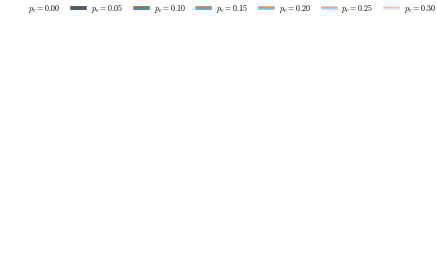

In [7]:
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection

# define an object that will be used by the legend
class MulticolorEntry(object):
    def __init__(self, colors, linestyle='-'):
        self.colors = colors
        self.linestyle = linestyle
        
# define a handler for the MulticolorPatch object
class MulticolorEntryHandler(object):
    def __init__(self, margin=0.1):
        self.margin = margin
    
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        x0, y0 = handlebox.xdescent, handlebox.ydescent

        paths = []
        codes = [mpath.Path.MOVETO, mpath.Path.LINETO]
        if len(orig_handle.colors) == 1:
            y = y0 + 0.5 * height
            verts = [(x0, y), (x0 + width, y)]
            paths.append(mpath.Path(verts, codes))
        else:
            # y0 += self.margin
            yusable = height * (1 - 2 * self.margin)
            offset = yusable / (len(orig_handle.colors) - 1)
            for i in range(len(orig_handle.colors)):
                verts = [(x0, y0 + offset * i), (x0 + width, y0 + offset * i)]
                paths.append(mpath.Path(verts, codes))

        artist = PatchCollection(
            [mpatches.PathPatch(p) for p in paths],
            match_original=True,
            # facecolors=orig_handle.colors,
            # linestyles=orig_handle.linestyle,
            # linewidths=[2] * len(orig_handle.colors),
        )
        handlebox.add_artist(artist)
        return artist

class HandlerMulticolorLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = mlines.Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[1] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


def export_legend(n_colors, fs=None):
    n_error_probs = 6
    palettes = [[] for _ in range(n_colors)]
    l_max = 0.9
    # lightness = [step * (i + 1) for i in range(n_error_probs)]
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    print(lightness)
    for l in lightness:
        colors = sns.husl_palette(n_colors, h=0.01 + 1 / 8, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    # for hue in hues:
    #    derived = sns.dark_palette(color=hue, n_colors=n_error_probs * 2 + 1)
    #    derived = derived[1:-1:2]
    #    palettes.append(derived)

    placeholder = mpatches.Patch(alpha=0)
    fig, ax = plt.subplots(1, figsize=inches(16,10))
    fig.set_dpi(72)
    wd = 2 * plt.rcParams['lines.linewidth']
    
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mlines.Line2D([0],[0], color='black', linestyle=':', linewidth=wd))
    handles.extend([
        LineCollection(n_colors * [[(0, 0)]], linestyles='-', colors=[p[i] for p in palettes], linewidths=wd)
        for i in range(len(palettes[0]))
    ])

    labels.extend([f'$p_e = {p:.2f}$' for p in np.arange(0, 0.35, 0.05, dtype=np.float64)])
    print(handles)

    fs = 8
    legend = fig.legend(
        handles, labels, ncols=7, loc=1,
        handler_map={LineCollection: HandlerMulticolorLines()},
        borderaxespad=0., frameon=False, framealpha=1,
        borderpad=0.2, fontsize=fs,  # mode="expand", 
        columnspacing=1.2,
        handletextpad=0.6,
    )
    
    fig  = legend.figure
    fig.canvas.draw()
    fig.axes[0].axis('off')
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bp = legend.borderpad * fs / 72 # plt.rcParams['font.size'] / 72
    x0 = bbox.x0 + (legend.handletextpad + legend.borderpad) * fs / 72 # plt.rcParams['font.size'] / 72
    y0 = bbox.y0 + 6 / 72
    bbox = mtransforms.Bbox.from_bounds(x0, y0, bbox.x1 - x0 + bp, bbox.y1 - y0)

    fig.savefig(f'../figs/legend-entropy-{n_colors}.pdf', format='pdf', dpi='figure', bbox_inches=bbox,  backend='pdf')

export_legend(4, None)

## Compositionality and generalization

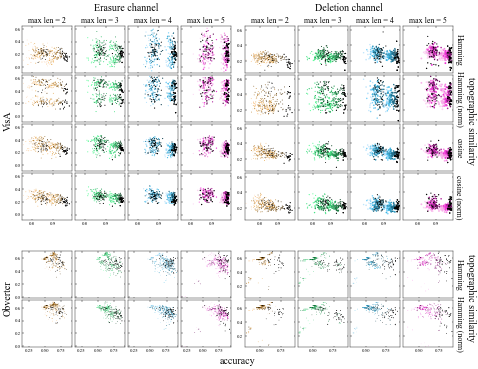

In [8]:
channels = ['erasure', 'deletion']

def plot(dfs, lengths, min_size=0.4, max_size=4):
    min_lex = min(df.unique_msg.min() for df in dfs)
    max_lex = max(df.unique_msg.max() for df in dfs)
    
    # get palette & linestyles
    n_error_probs = 6
    palettes = [[(0, 0, 0)] for _ in range(len(lengths))]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(len(lengths), h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)

    fig = plt.figure(figsize=inches(15.7, 12.5), dpi=72)
    subfigs = fig.subfigures(2, len(channels), wspace=0, hspace=0, height_ratios=[2, 1])
    channel_axes = {}
    for (c, channel), (d, df) in product(enumerate(channels), enumerate(dfs)):
        subfig = subfigs[d, c]
        # subfig.set_facecolor((str(1-0.1*(c+1)), 0.5))
        if d == 0:
            subfig.suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.00)
        if channel == 'erasure':
            subfig.supylabel('VisA' if d == 0 else 'Obverter', fontsize=10, ha='right', x=-0.01)
        else:
            subfig.supylabel('topographic similarity', fontsize=10, ha='left', x=1.025, rotation=270)

        metrics = ('topsim', 'topsim_norm', 'topsim_cosine', 'topsim_cosine_norm') \
            if d == 0 else ('topsim', 'topsim_norm')
        channel_axes[channel] = subfig.subplots(
            len(metrics), len(lengths),
            gridspec_kw={'wspace': 4 / 72, 'hspace': 4 / 72},
            sharex=True, sharey=True)
            
        # for c, channel in enumerate(channels):
        for m, metric in enumerate(metrics):
            for l, length in enumerate(lengths):
                data = df[(df.channel == channel) & (df.max_len == length)]
                data = data[['error_prob', 'accuracy', metric, 'unique_msg']]
                ax = channel_axes[channel][m, l]

                _min = data.unique_msg.min()
                _max = data.unique_msg.max()
                sizes = (
                    (_min - min_lex) / (max_lex - min_lex) * (max_size - min_size) + min_size,
                    (_max - min_lex) / (max_lex - min_lex) * (max_size - min_size) + min_size,
                )

                sns.scatterplot(
                    data=data.sort_values(by='error_prob', ascending=False),
                    x='accuracy', y=metric,
                    size='unique_msg',
                    # sizes=(0.4, 3.2),
                    sizes=sizes,
                    # s=1.5,
                    hue='error_prob',
                    palette=palettes[l],
                    linewidths=0,
                    hue_order=list(x / 100 for x in range(0, 35, 5)),
                    ax=ax, legend=None, zorder=1.5,
                )
                
                ax.tick_params(
                    which='major',
                    labelbottom=(m + 1 == len(metrics)),
                    labelleft=(l == 0),
                    labeltop=False,
                    labelright=False,
                    labelsize=5,
                )
                ax.tick_params(
                    which='minor',
                    labelbottom=False,
                    labelleft=False,
                    labeltop=False,
                    labelright=False,
                )

                if m == 0 and d == 0:
                    ax.set_xlabel(f'max len = {length}', visible=True, fontsize='medium')
                    ax.xaxis.set_label_position("top")
                else:
                    ax.set_xlabel(None)

                if channel == channels[-1] and l + 1 == len(lengths):
                    ax.yaxis.set_label_position("right")
                    if metric == 'topsim':
                        metric_name = 'Hamming'
                    elif metric == 'topsim_norm':
                        metric_name = 'Hamming (norm)'
                    elif metric == 'topsim_cosine':
                        metric_name = 'cosine'
                    elif metric == 'topsim_cosine_norm':
                        metric_name = 'cosine (norm)'
                    ax.set_ylabel(metric_name, rotation=270, fontsize='medium', visible=True, va='baseline')
                else:
                    ax.set_ylabel(None)
                    # ax.set_ylabel(metric, visible=False)#None)
        # subfig.supxlabel('accuracy', fontsize=10, va='baseline', y=0.0)
    fig.supxlabel('accuracy', fontsize=10, va='baseline', y=-0.02)
    # fig.supylabel('topographic similarity', fontsize=10, rotation=270, x=1.02, ha='left')

    # share y axes between subfigures for each metric
    # for m, metric in enumerate(metrics):#range(len(metrics)):
    #     axs = [ax for subfig in subfigs for ax in subfig.axes[m*len(lengths):(m+1)*len(lengths)]]
    #     for ax in axs[1:]:
    #         ax.sharey(axs[0])
    #     ax.autoscale(axis='y') 

    # add padding
    top_padding = inches(1.25)
    bottom_padding = inches(1)
    sides_padding = inches(0.5)
    w, h = fig.get_size_inches()
    b, t = bottom_padding / h, 1 - top_padding / h
    l, r = sides_padding / w, 1 - sides_padding / w
    fig.subplots_adjust(top=t, bottom=b, left=l, right=r)
    plt.show()

    fig.savefig(
        f'../figs/fig-scatter.pdf', format='pdf', dpi='figure',
        # bbox_inches='tight', pad_inches=0.5, backend='pgf',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot(
    [final_visa[final_visa.messages == 'sent'], final_img[final_img.messages == 'sent']],
    [2, 3, 4, 5],
)

In [9]:
final_visa.columns

Index(['max_len', 'channel', 'error_prob', 'messages', 'samples',
       'samples_per_target_obj', 'samples_per_cat', 'unique_msg',
       'unique_samples', 'unique_target_objs', 'unique_target_objs_per_msg',
       'unique_samples_per_target_obj', 'unique_samples_cat', 'unique_cat',
       'unique_samples_per_target_cat', 'unique_cats_per_msg',
       'average_length', 'actual_vocab_size', 'accuracy', 'accuracy_deletion',
       'accuracy_replacement', 'accuracy_permutation_2', 'redundancy_act',
       'redundancy_max', 'topsim', 'topsim_norm', 'topsim_cosine',
       'topsim_cosine_norm', 'entropy_msg', 'entropy_max_actlen',
       'entropy_max_maxlen', 'mutual_info_sent_received', 'entropy_target',
       'mutual_info_msg_target', 'proficiency_msg_target', 'entropy_selected',
       'mutual_info_msg_selected', 'proficiency_msg_selected',
       'entropy_target_category', 'mutual_info_msg_target_category',
       'proficiency_msg_target_category', 'kld_train_test', 'kld_test_train',


In [10]:
print(final_visa.messages.unique())

['received' 'sent']


### Sent and received

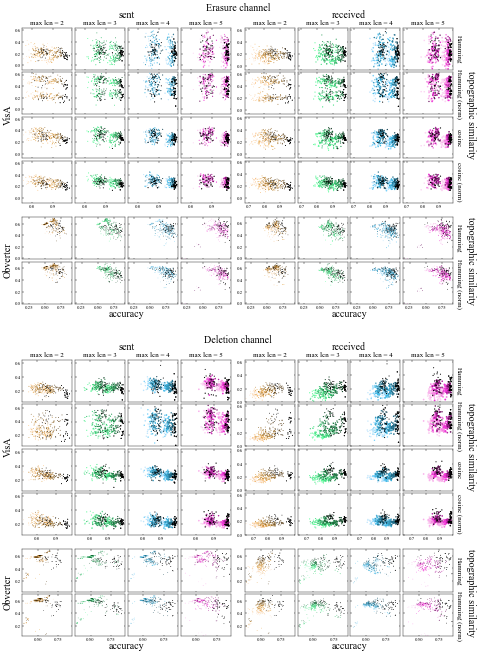

In [11]:
channels = ['erasure', 'deletion']

def plot(dfs, lengths, min_size=0.4, max_size=4):
    min_lex = min(df.unique_msg.min() for df in dfs)
    max_lex = max(df.unique_msg.max() for df in dfs)
    
    
    # get palette & linestyles
    n_error_probs = 6
    palettes = [[(0, 0, 0)] for _ in range(len(lengths))]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(len(lengths), h=0.01 + 1 / 8, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)

    fig = plt.figure(figsize=inches(15.7, 22), dpi=72)
    outer_subfigs = fig.subfigures(2, hspace=10 / 72)
    channel_axes = {}
    for c, channel in enumerate(channels):
        inner_subfigs = outer_subfigs[c].subfigures(
            2, len(channels), wspace=0, hspace=0, height_ratios=[2, 1]
        )
        for (d, df), (i, messages) in product(enumerate(dfs), enumerate(['sent', 'received'])):
            subfig = inner_subfigs[d, i]
            # subfig.set_facecolor((str(1-0.1*(c+1)), 0.5))
            if d == 0:
                outer_subfigs[c].suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.05)
                subfig.suptitle(messages, fontsize=10, y=1.04)
            if i == 0:
                formatted = 'VisA' if d == 0 else 'Obverter'
                subfig.supylabel(formatted, fontsize=10, ha='right', x=-0.01)
            else:
                subfig.supylabel('topographic similarity', fontsize=10, ha='left', x=1.025, rotation=270)

            metrics = ('topsim', 'topsim_norm', 'topsim_cosine', 'topsim_cosine_norm') \
                if d == 0 else ('topsim', 'topsim_norm')
            channel_axes[channel] = subfig.subplots(
                len(metrics), len(lengths),
                gridspec_kw={'wspace': 4 / 72, 'hspace': 4 / 72},
                sharex=True, sharey=True)
            
            # for c, channel in enumerate(channels):
            for m, metric in enumerate(metrics):
                for l, length in enumerate(lengths):
                    data = df[(df.channel == channel) & (df.max_len == length) & (df.messages == messages)]
                    data = data[['error_prob', 'accuracy', metric, 'unique_msg']]
                    ax = channel_axes[channel][m, l]

                    _min = data.unique_msg.min()
                    _max = data.unique_msg.max()
                    sizes = (
                        (_min - min_lex) / (max_lex - min_lex)
                        * (max_size - min_size) + min_size,
                        (_max - min_lex) / (max_lex - min_lex)
                        * (max_size - min_size) + min_size,
                    )
                    
                    sns.scatterplot(
                        data=data.sort_values(by='error_prob', ascending=False),
                        x='accuracy', y=metric,
                        size='unique_msg',
                        # sizes=(0.4, 3.2),
                        sizes=sizes,
                        # s=1.5,
                        hue='error_prob',
                        palette=palettes[l],
                        linewidths=0,
                        hue_order=list(x / 100 for x in range(0, 35, 5)),
                        ax=ax, legend=None, zorder=1.5,
                    )
                
                    ax.tick_params(
                        which='major',
                        labelbottom=(m + 1 == len(metrics)),
                        labelleft=(l == 0),
                        labeltop=False,
                        labelright=False,
                        labelsize=5,
                    )
                    ax.tick_params(
                        which='minor',
                        labelbottom=False,
                        labelleft=False,
                        labeltop=False,
                        labelright=False,
                    )

                    if m == 0 and d == 0:
                        ax.set_xlabel(f'max len = {length}', visible=True, fontsize=7)
                        ax.xaxis.set_label_position("top")
                    else:
                        ax.set_xlabel(None)

                    # if channel == channels[0] and l == 0:
                    # if channel == channels[-1] and
                    if l + 1 == len(lengths) and i == 1:
                        ax.yaxis.set_label_position("right")
                        if metric == 'topsim':
                            metric_name = 'Hamming'
                        elif metric == 'topsim_norm':
                            metric_name = 'Hamming (norm)'
                        elif metric == 'topsim_cosine':
                            metric_name = 'cosine'
                        elif metric == 'topsim_cosine_norm':
                            metric_name = 'cosine (norm)'
                        ax.set_ylabel(metric_name, rotation=270, fontsize=7, visible=True, va='baseline')
                    else:
                        ax.set_ylabel(None)
                        # ax.set_ylabel(metric, visible=False)#None)
            if d == 1:
                subfig.supxlabel('accuracy', fontsize=10, va='baseline', y=-0.085)
        # fig.supxlabel('accuracy', fontsize=10, va='baseline', y=-0.02)
        # outer_subfigs[c].supylabel('topographic similarity', fontsize=10, rotation=270, x=1.01, ha='left')

        # share y axes between subfigures for each metric
        # for m, metric in enumerate(metrics):#range(len(metrics)):
        #     axs = [ax for subfig in subfigs for ax in subfig.axes[m*len(lengths):(m+1)*len(lengths)]]
        #     for ax in axs[1:]:
        #         ax.sharey(axs[0])
        #     ax.autoscale(axis='y') 

    # add padding
    top_padding = inches(1.25)
    bottom_padding = inches(1)
    sides_padding = inches(0.5)
    w, h = fig.get_size_inches()
    b, t = bottom_padding / h, 1 - top_padding / h
    l, r = sides_padding / w, 1 - sides_padding / w
    fig.subplots_adjust(top=t, bottom=b, left=l, right=r)
    plt.show()

    fig.savefig(
        f'../figs/fig-scatter-v2.pdf', format='pdf', dpi='figure',
        # bbox_inches='tight', pad_inches=0.5, backend='pgf',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot(
    # [final_visa[final_visa.messages == 'sent'], final_img[final_img.messages == 'sent']],
    [final_visa, final_img],
    [2, 3, 4, 5],
)

#### Legend

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


3.6897856517935255 3.9370078740157473


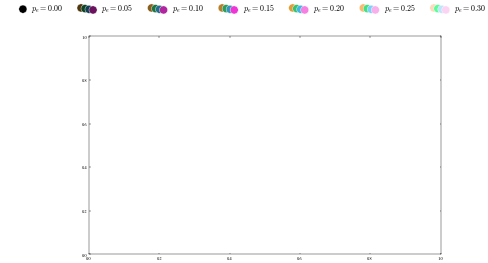

In [12]:
# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors, marker='o'):
        self.colors = colors
        self.marker = mmark.MarkerStyle(marker, fillstyle='full')
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        paths = [mmark.MarkerStyle(orig_handle.marker, fillstyle='full').get_path()] * len(orig_handle.colors)
        # orig_size = paths[0].get_sizes()
        # print(orig_size)
        dpi = legend.figure.get_dpi()
        marker_size = (fontsize * 2)
        size = marker_size ** 2
        # print('s, ms', size, marker_size, dpi, paths[0])
        # print(width, height, handlebox.xdescent, handlebox.ydescent)

        if len(orig_handle.colors) > 1:
            wd = min(width, marker_size * (len(paths) + 1) / 2)
            sep = wd / (len(paths))
            # x0 = marker_size / 2  #size / 2#(width - wd + size) / 2
            x0 = sep / 2  # y = marker_size / 4 + (plt.rcParams['font.size'] - marker_size) / 4
            yoffset = fontsize / 4 / (len(paths) - 1)
            y0 = marker_size / 4 + (fontsize - marker_size) / 4 + yoffset  # y = marker_size / 4
        else:
            wd = min(width, marker_size * (5) / 2)
            x0  = wd / 4 * 3.5
            
            # x0 = width - wd / 4  # - marker_size / 2
            # y0 = (fontsize - marker_size) / 4 + 
            y0 = marker_size / 4 + (fontsize - marker_size) / 4  # + fontsize / 4
            sep = yoffset = 0

        border_wd = plt.rcParams['lines.linewidth']

        # print(width, wd, sep, x0)  print([x0 + sep * i for i in range(len(paths))])
        artist = PathCollection(
            paths,
            sizes=[marker_size + border_wd for _ in paths],
            offsets = [(x0 + sep * i, y0 - i * yoffset) for i in range(len(paths))],
            facecolors=orig_handle.colors, linewidths=border_wd, edgecolors='white',
            # linewidths=[lw] * len(paths),
        )

        handlebox.add_artist(artist)

class LineHandler(HandlerLine2D):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        xdescent, ydescent, width, height = self.adjust_drawing_area(
            legend, orig_handle,
            handlebox.xdescent, handlebox.ydescent,
            handlebox.width, handlebox.height,
            fontsize,
        )
        ydescent += fontsize / 4  # height -= fontsize / 2
        artists = self.create_artists(
            legend, orig_handle, xdescent, ydescent,
            width, height, fontsize, handlebox.get_transform()
        )
        for a in artists:
            handlebox.add_artist(a)
        print('line', handlebox.height, handlebox.ydescent)

        return artists[0]


def export_legend(n_colors, fs=None):
    bright_colors, dark_colors = get_palette(n_colors, l_bright, l_dark)

    placeholder = mpatches.Patch(alpha=0)
    fig, ax = plt.subplots(1, figsize=inches(16,10))
    fig.set_dpi(72)
    wd = 2 * plt.rcParams['lines.linewidth']
    
    handles, labels = ax.get_legend_handles_labels()

    # get palette & linestyles
    n_error_probs = 6
    palettes = [[(0, 0, 0)] for _ in range(n_colors)]
    l_max = 0.9
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(n_colors, h=0.01 + 1 / 8, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)

    handles.extend([
        MulticolorPatch([p[i] for p in palettes]) if i > 0 else MulticolorPatch([palettes[0][i]])
        for i in range(7)
    ])
    labels.extend([f'$p_e = {p:.2f}$' for p in np.arange(0, 0.35, 0.05, dtype=np.float64)])

    fs = plt.rcParams['font.size'] if fs is None else fs
    legend = fig.legend(
        handles, labels, ncols=7, loc=1,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), mlines.Line2D: LineHandler()},
        borderaxespad=0., frameon=False, framealpha=1,
        borderpad=0.3, fontsize=fs,  # mode="expand", 
    )
    
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    # print(bbox, legend.columnspacing, legend.handlelength)
    bp = legend.borderpad * fs / 72 # plt.rcParams['font.size'] / 72
    fig.savefig(f'../figs/legend-scatter-{n_colors}-0.pdf', format='pdf', dpi='figure', bbox_inches=bbox)# backend='pdf')
    x0 = bbox.x0 + (legend.handletextpad + legend.handlelength) * fs / 72 # plt.rcParams['font.size'] / 72
    print(bbox.y0, bbox.y1)
    # x1 = bbox.x1 - x0 - 
    # print(bbox)
    
    bbox = mtransforms.Bbox.from_bounds(x0, bbox.y0 + 0.05, bbox.x1 - x0 + bp, bbox.y1 - bbox.y0 - 0.05)
    # bbox = mtransforms.Bbox.from_bounds(x0, bbox.y0, x1, bbox.y1 - bbox.y0)
    # print(bbox)
    # fig.savefig('legend.png', format='png', dpi='figure', bbox_inches=bbox)
    fig.savefig(f'../figs/legend-scatter-{n_colors}.pdf', format='pdf', dpi='figure', bbox_inches=bbox,  backend='pdf')

export_legend(4, None)

## Communicated attributes – Obverter

In [13]:
final_visa.columns

Index(['max_len', 'channel', 'error_prob', 'messages', 'samples',
       'samples_per_target_obj', 'samples_per_cat', 'unique_msg',
       'unique_samples', 'unique_target_objs', 'unique_target_objs_per_msg',
       'unique_samples_per_target_obj', 'unique_samples_cat', 'unique_cat',
       'unique_samples_per_target_cat', 'unique_cats_per_msg',
       'average_length', 'actual_vocab_size', 'accuracy', 'accuracy_deletion',
       'accuracy_replacement', 'accuracy_permutation_2', 'redundancy_act',
       'redundancy_max', 'topsim', 'topsim_norm', 'topsim_cosine',
       'topsim_cosine_norm', 'entropy_msg', 'entropy_max_actlen',
       'entropy_max_maxlen', 'mutual_info_sent_received', 'entropy_target',
       'mutual_info_msg_target', 'proficiency_msg_target', 'entropy_selected',
       'mutual_info_msg_selected', 'proficiency_msg_selected',
       'entropy_target_category', 'mutual_info_msg_target_category',
       'proficiency_msg_target_category', 'kld_train_test', 'kld_test_train',


Shape Color X Y
Sent Received
Erasure Deletion
2 3 4 5 

Channels - 2 outer rows
2345 - 4 - outer columns
Shape color X Y - 4 Inner rows
Sent received - 2 inner columns

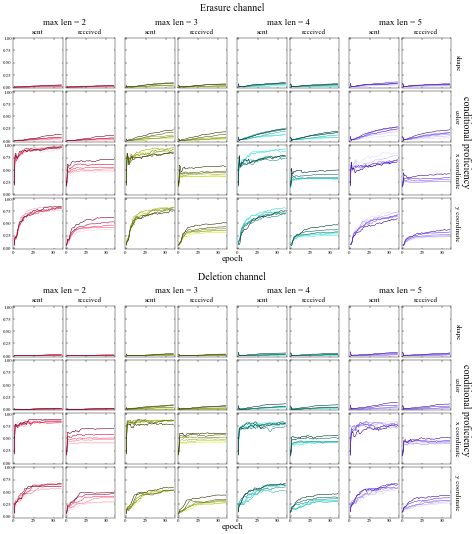

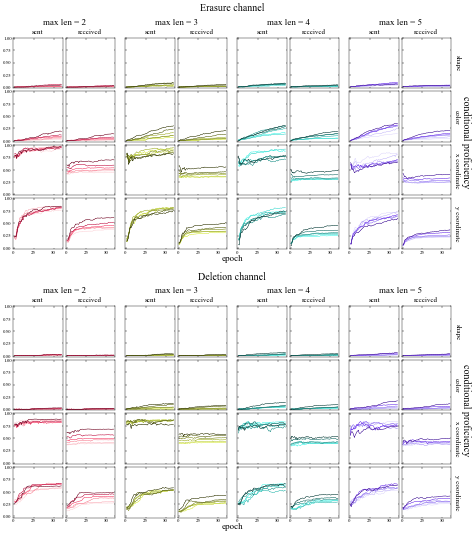

In [14]:
channels = ['erasure', 'deletion']
attributes = ('shape', 'color', 'x coordinate', 'y coordinate')
variables = [f'proficiency_msg_target_{a}' for a in ('shape', 'color', 'x', 'y')]

def plot(df, lengths, ds):
    # get palette & linestyles
    n_error_probs = 6
    palettes = [[(0, 0, 0)] for _ in range(len(lengths))]
    l_max, base = 0.9, 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(len(lengths), h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
    linestyles = [dots] + [lines] * n_error_probs
    order = np.round(np.arange(0, 0.35, 0.05), decimals=3).tolist()[::-1]

    # create fig
    fig = plt.figure(figsize=inches(15.7, 18), dpi=72)
    outer_subfigs = fig.subfigures(len(channels), hspace=8 / 72)
    axes = {}
    for c, channel in enumerate(channels):
        outer_subfigs[c].suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.075)
        inner_subfigs = outer_subfigs[c].subfigures(1, len(lengths), wspace=2/72, hspace=0)
        outer_subfigs[c].supxlabel('epoch', fontsize=9, y=0.0)
        outer_subfigs[c].supylabel('conditional proficiency', fontsize=10, rotation=270, x=1.015, ha='left')
        # inner_subfigs[-1].supxlabel('epoch', fontsize=10)
        for l, length in enumerate(lengths):
            data = df[(df.channel == channel) & (df.max_len == length)]
            inner_subfigs[l].suptitle(f'max len = {length}', fontsize=9, y=1.01)
            # subfig.set_facecolor((str(1-0.1*(c+1)), 0.5))
            # if d == 0:
            #     outer_subfigs[c].suptitle(f'{channel} channel'.capitalize(), fontsize=10, y=1.05)
            #     subfig.suptitle(messages, fontsize=10, y=1.04)
            axes[c, l] = inner_subfigs[l].subplots(
                len(variables), 2,
                gridspec_kw={'wspace': 4 / 72, 'hspace': 4 / 72},
                sharex=False, sharey=False)
            
            for (v, variable), (m, messages) in product(
                enumerate(variables), enumerate(['sent', 'received'])
            ):
                ax = axes[c, l][v, m]
                sns.lineplot(
                    data=data[data.messages == messages],
                    x='epoch', y=variable, hue='error_prob', style='error_prob',
                    palette=palettes[l][::-1], dashes=linestyles[::-1],
                    hue_order=order, style_order=order,
                    ax=ax, legend=None, zorder=1.5, errorbar=None,
                )
                ax.tick_params(
                    which='major',
                    labelbottom=(v + 1 == len(variables)),
                    labelleft=(l == m == 0),
                    labeltop=False, labelright=False,
                    labelsize=5,
                )
                if v == 0:
                    ax.set_xlabel(messages, visible=True, fontsize=7)
                    ax.xaxis.set_label_position("top")
                else:
                    ax.set_xlabel(None)
                if l + 1 == len(lengths) and m == 1:
                    ax.yaxis.set_label_position("right")
                    ax.set_ylabel(attributes[v], rotation=270, visible=True, fontsize=7, va='baseline', x=1.01)
                else:
                    ax.set_ylabel(None)

    # share y axes between subfigures for each metric
    axs = [ax for subfig in axes.values() for axs in subfig for ax in axs]
    for ax in axs[1:]:
        ax.sharey(axs[0])
    axs[0].autoscale(axis='y')

    # add padding
    top_padding = inches(1.25)
    bottom_padding = inches(1)
    sides_padding = inches(0.5)
    w, h = fig.get_size_inches()
    b, t = bottom_padding / h, 1 - top_padding / h
    l, r = sides_padding / w, 1 - sides_padding / w
    fig.subplots_adjust(top=t, bottom=b, left=l, right=r)
    plt.show()

    fig.savefig(
        f'../figs/fig-attributes-{ds}.pdf', format='pdf', dpi='figure',
        bbox_inches='tight', pad_inches=0.4 / 72,
    )
    close_plot(fig)
    gc.collect()

plot(history_img[history_img.phase == 'train'], [2, 3, 4, 5], 'train')
plot(history_img[history_img.phase == 'test'], [2, 3, 4, 5], 'test')

### Legend

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


[0.24973819 0.43489653 0.58210387 0.704302   0.80876723 0.9       ]
[<matplotlib.lines.Line2D object at 0x7f7c66ea0ca0>, <matplotlib.collections.LineCollection object at 0x7f7c8f200d30>, <matplotlib.collections.LineCollection object at 0x7f7c8f200cd0>, <matplotlib.collections.LineCollection object at 0x7f7c8dce6460>, <matplotlib.collections.LineCollection object at 0x7f7c8f5bbe80>, <matplotlib.collections.LineCollection object at 0x7f7c8e4906d0>, <matplotlib.collections.LineCollection object at 0x7f7c8dfe08e0>]


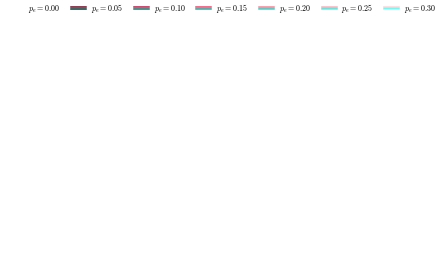

In [15]:
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection

# define an object that will be used by the legend
class MulticolorEntry(object):
    def __init__(self, colors, linestyle='-'):
        self.colors = colors
        self.linestyle = linestyle
        
# define a handler for the MulticolorPatch object
class MulticolorEntryHandler(object):
    def __init__(self, margin=0.1):
        self.margin = margin
    
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        x0, y0 = handlebox.xdescent, handlebox.ydescent

        paths = []
        codes = [mpath.Path.MOVETO, mpath.Path.LINETO]
        if len(orig_handle.colors) == 1:
            y = y0 + 0.5 * height
            verts = [(x0, y), (x0 + width, y)]
            paths.append(mpath.Path(verts, codes))
        else:
            # y0 += self.margin
            yusable = height * (1 - 2 * self.margin)
            offset = yusable / (len(orig_handle.colors) - 1)
            for i in range(len(orig_handle.colors)):
                verts = [(x0, y0 + offset * i), (x0 + width, y0 + offset * i)]
                paths.append(mpath.Path(verts, codes))

        artist = PatchCollection(
            [mpatches.PathPatch(p) for p in paths],
            match_original=True,
            # facecolors=orig_handle.colors,
            # linestyles=orig_handle.linestyle,
            # linewidths=[2] * len(orig_handle.colors),
        )
        handlebox.add_artist(artist)
        return artist

class HandlerMulticolorLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = mlines.Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[1] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


def export_legend(n_colors, fs=None):
    n_error_probs = 6
    palettes = [[] for _ in range(n_colors)]
    l_max = 0.9
    # lightness = [step * (i + 1) for i in range(n_error_probs)]
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    print(lightness)
    for l in lightness:
        colors = sns.husl_palette(n_colors, h=0.01, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    # for hue in hues:
    #     
    #    derived = sns.dark_palette(color=hue, n_colors=n_error_probs * 2 + 1)
    #    derived = derived[1:-1:2]
    #    palettes.append(derived)

    placeholder = mpatches.Patch(alpha=0)
    fig, ax = plt.subplots(1, figsize=inches(16,10))
    fig.set_dpi(72)
    wd = 2 * plt.rcParams['lines.linewidth']
    
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mlines.Line2D([0],[0], color='black', linestyle=':', linewidth=wd))
    handles.extend([
        LineCollection(n_colors * [[(0, 0)]], linestyles='-', colors=[p[i] for p in palettes], linewidths=wd)
        for i in range(len(palettes[0]))
    ])

    labels.extend([f'$p_e = {p:.2f}$' for p in np.arange(0, 0.35, 0.05, dtype=np.float64)])
    print(handles)

    fs = 8
    legend = fig.legend(
        handles, labels, ncols=7, loc=1,
        handler_map={LineCollection: HandlerMulticolorLines()},
        borderaxespad=0., frameon=False, framealpha=1,
        borderpad=0.2, fontsize=fs,  # mode="expand", 
        columnspacing=1.2,
        handletextpad=0.6,
    )
    
    fig  = legend.figure
    fig.canvas.draw()
    fig.axes[0].axis('off')
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    bp = legend.borderpad * fs / 72 # plt.rcParams['font.size'] / 72
    x0 = bbox.x0 + (legend.handletextpad + legend.borderpad) * fs / 72 # plt.rcParams['font.size'] / 72
    y0 = bbox.y0 + 6 / 72
    bbox = mtransforms.Bbox.from_bounds(x0, y0, bbox.x1 - x0 + bp, bbox.y1 - y0)

    fig.savefig(f'../figs/legend-proficiency-{n_colors}.pdf', format='pdf', dpi='figure', bbox_inches=bbox,  backend='pdf')

export_legend(4, None)

## Accuracy after disruption 

### Full page

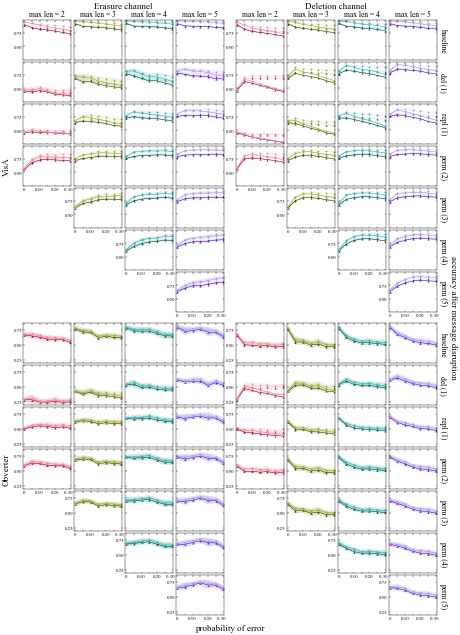

In [249]:
channels = ['erasure', 'deletion']
variables = ['accuracy'] + [
    f'accuracy_{suffix}' for suffix in (
        'deletion', 'replacement', 'permutation_2',
        'permutation_3', 'permutation_4', 'permutation_5',
    )
]
lengths = range(2, 6)


def plot(*dfs):
    bright_colors, dark_colors = get_palette(len(lengths), 0.7, 0.3)
    err_bright, err_dark = get_palette(len(lengths), 0.65, 0.35)

    w, h = 14.55, 21
    fig = plt.figure(figsize=inches(w, h), dpi=72)
    outer_subfigs = fig.subfigures(2, 1, hspace= 4 / 72 * w / h)

    axes = {}
    for d, df in enumerate(dfs):
        inner_subfigs = outer_subfigs[d].subfigures(1, len(channels), wspace=4 / 72, hspace=0 / 72)
        for c, channel in enumerate(channels):
            subfig = inner_subfigs[c]
            if d == 0:
                subfig.suptitle(f'{channel} channel'.capitalize(), fontsize=9, y=1.04, va='baseline')
            if channel == 'erasure':
                subfig.supylabel('VisA' if d == 0 else 'Obverter', fontsize=9, ha='right', x=-0.06)
            subplots = subfig.subplots(
                len(variables), len(lengths),
                gridspec_kw={
                    'wspace': 4 / 72 * len(lengths) / (len(variables) - 1) * h / w,
                    'hspace': 4 / 72, 'top': 1, 'bottom': 0, 'left': 0, 'right': 1,
                },
                sharex=True, sharey=False,
            )
            
            for (v, variable), (l, length) in product(
                enumerate(variables), enumerate(lengths),
            ):
                ax = axes[d, c, v, l] = subplots[v, l]
                n_symbols = int(variable.split('_')[-1]) if 'permutation' in variable else 1
                if length < n_symbols:
                    ax.axis('off')
                    continue

                data = df[(df.channel == channel) & (df.max_len == length)]
                data = data.assign(noise_dataset=(data.dataset + ' ' + data.messages))
                data = data[['error_prob', 'noise_dataset', variable]]

                lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
                sns.lineplot(
                    data=data,
                    x='error_prob', y=variable,
                    hue='noise_dataset', style='noise_dataset',
                    # hue_order=('train received', 'train sent', 'test received', 'test sent'),
                    # style_order=('train received', 'train sent', 'test received', 'test sent'),
                    # palette=(bright_colors[l], bright_colors[l], dark_colors[l], dark_colors[l]),
                    markers=('^', '^', 'o', 'o'), markeredgewidth=0,   
                    hue_order=('test received', 'test sent', 'train received', 'train sent'),
                    style_order=('test received', 'test sent', 'train received', 'train sent'),
                    palette=(dark_colors[l], dark_colors[l], bright_colors[l], bright_colors[l]),
                    dashes=[lines, dots, lines, dots],
                    errorbar=('se', 2), seed=42,
                    ax=ax, legend=None, zorder=1.5,
                    err_kws={
                        'alpha': 0.12,
                        'facecolors': [err_bright[l], err_bright[l], err_dark[l], err_dark[l]],
                    },
                )

                show_yticks = (length == n_symbols) if 'permutation' in variable else (l == 0)
                show_xticks = show_yticks and 'permutation' in variable
                ax.tick_params(
                    which='major',
                    labelleft=show_yticks, labelbottom=show_xticks,
                    labeltop=False, labelright=False,
                    labelsize=5,
                    # pad=1,
                )
                ax.tick_params(
                    which='minor',
                    labelbottom=False, labelleft=False,
                    labeltop=False, labelright=False,
                )
                xticks = np.arange(0, 0.35, 0.10)
                xticklabels = [f'{x:.2f}' if x > 0 else '0' for x in xticks ]
                xticklabels[-1] = xticklabels[-1] + '   '
                ax.set_xticks(ticks=np.arange(0, 0.35, 0.10), labels=xticklabels)
                ax.set_xticks(ticks=np.arange(0, 0.35, 0.05), minor=True)
                ax.tick_params(axis='y', pad=0.8)

                if v == d == 0:
                    ax.set_xlabel(f'max len = {length}', visible=True, fontsize=7.5)
                    ax.xaxis.set_label_position("top")
                else:
                    ax.set_xlabel(None)
                    
                if channel == channels[-1] and l + 1 == len(lengths):
                    if variable != 'accuracy':
                        disruption_type = variable.split('_')[1]
                        disruption_abbr = 'del' if disruption_type == 'deletion' else disruption_type[:4]
                        varname = f'{disruption_abbr} ({n_symbols})'
                    else:
                        varname = 'baseline'
                    ax.yaxis.set_label_position("right")
                    ax.set_ylabel(varname, rotation=270, fontsize=7.5, visible=True, va='baseline')
                else:
                    ax.set_ylabel(None)
    fig.supylabel(
        'accuracy after message disruption',
        fontsize=9, x=1.03, ha='left', rotation=270,
    )
    fig.supxlabel('probability of error', fontsize=9, va='top', y=-0.015)
        
    # share y axes between subfigures for each variable, separately for each dataset
    for d in range(2):
        axs = list(axes.values())
        axs = [ax for key, ax in axes.items() if key[0] == d]
        for ax in axs[1:]:
            ax.sharey(axs[0])
        ax.autoscale(axis='y') 
    
    plt.show()
    fig.savefig(
        f'../figs/fig-disruption-all.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot(final_visa, final_img)

#### v1

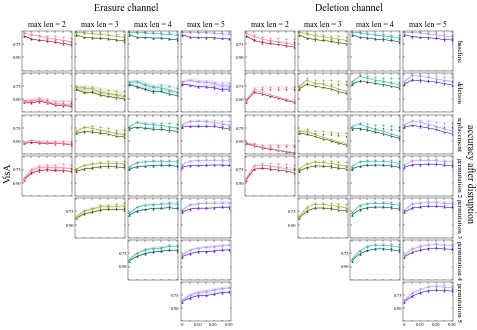

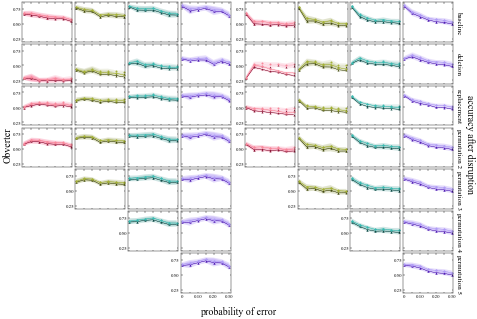

In [16]:
channels = ['erasure', 'deletion']
variables = ['accuracy'] + [
    f'accuracy_{suffix}' for suffix in (
        'deletion', 'replacement', 'permutation_2',
        'permutation_3', 'permutation_4', 'permutation_5',
    )
]


def plot(df, lengths, ds):
    bright_colors, dark_colors = get_palette(len(lengths), 0.7, 0.3)
    err_bright, err_dark = get_palette(len(lengths), 0.55, 0.45)

    fig = plt.figure(figsize=inches(15.7, 12.5), dpi=72)
    subfigs = fig.subfigures(1, len(channels), wspace=0, hspace=0)
    channel_axes = {}
    for c, channel in enumerate(channels):
        subfig = subfigs[c]
        # subfig.set_facecolor((str(1-0.1*(c+1)), 0.5))
        if ds == 'visa':
            subfig.suptitle(f'{channel} channel'.capitalize(), fontsize=10)
        if channel == 'erasure':
            formatted = 'VisA' if ds.lower() == 'visa' else 'Obverter'
            subfig.supylabel(formatted, fontsize=10, ha='right', x=-0.01)
        channel_axes[channel] = subfig.subplots(
            len(variables), len(lengths),
            gridspec_kw={'wspace': 4 / 72, 'hspace': 4 / 72},
            sharex=True, sharey=False)
            
        for v, variable in enumerate(variables):
            for l, length in enumerate(lengths):
                n_symbols = int(variable.split('_')[-1]) if 'permutation' in variable else 1
                ax = channel_axes[channel][v, l]
                if length < n_symbols:
                    ax.axis('off')
                    continue

                data = df[(df.channel == channel) & (df.max_len == length)]
                data = data.assign(noise_dataset=(data.dataset + ' ' + data.messages))
                data = data[['error_prob', 'noise_dataset', variable]]

                # triangle = mmark.MarkerStyle('^', fillstyle='full')
                # circle = mmark.MarkerStyle('o', fillstyle='full')
                lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
                sns.lineplot(
                    data=data,
                    x='error_prob', y=variable,
                    hue='noise_dataset', style='noise_dataset',
                    # hue_order=('train received', 'train sent', 'test received', 'test sent'),
                    # style_order=('train received', 'train sent', 'test received', 'test sent'),
                    # palette=(bright_colors[l], bright_colors[l], dark_colors[l], dark_colors[l]),
                    markers=('^', '^', 'o', 'o'), markeredgewidth=0,   
                    hue_order=('test received', 'test sent', 'train received', 'train sent'),
                    style_order=('test received', 'test sent', 'train received', 'train sent'),
                    palette=(dark_colors[l], dark_colors[l], bright_colors[l], bright_colors[l]),
                    # markers=('o', 'o', '^', '^'), markeredgewidth=0,
                    dashes=[lines, dots, lines, dots],
                    errorbar=('se', 2), seed=42,
                    ax=ax, legend=None, zorder=1.5,
                    err_kws={'alpha': 0.12, 'facecolors': [err_bright[l], err_bright[l], err_dark[l], err_dark[l]]},#, 'hatch': ['/', '\\', '|', '-']},
                )

                show_yticks = (length == n_symbols) if 'permutation' in variable else (l == 0)
                ax.tick_params(
                    which='major',
                    labelbottom=(v + 1 == len(variables)),
                    labelleft=show_yticks,
                    labeltop=False,
                    labelright=False,
                    labelsize=5,
                )
                ax.tick_params(
                    which='minor',
                    labelbottom=False,
                    labelleft=False,
                    labeltop=False,
                    labelright=False,
                )
                ax.set_xticks(ticks=np.arange(0, 0.35, 0.10))
                ax.set_xticks(ticks=np.arange(0, 0.35, 0.05), minor=True)
                ax.tick_params(axis='y', pad=0.8)
                ax.xaxis.set_major_formatter(lambda x, pos: f'{x:.2f}' if x > 0 else '0')

                if v == 0 and ds == 'visa':
                    ax.set_xlabel(f'max len = {length}', visible=True, fontsize='medium')
                    ax.xaxis.set_label_position("top")
                else:
                    ax.set_xlabel(None)
                    
                if channel == channels[-1] and l + 1 == len(lengths):
                    ax.yaxis.set_label_position("right")
                    var_name = variable.replace('accuracy_', '').replace('_', ' ') \
                        if variable != 'accuracy' else 'baseline'
                    ax.set_ylabel(var_name, rotation=270, fontsize=7, visible=True, va='baseline')
                else:
                    ax.set_ylabel(None)
                    # ax.set_ylabel(variable, visible=False)#None)
    if ds == 'img':
        fig.supxlabel('probability of error', fontsize=10, va='baseline', y=0.02)
    fig.supylabel('accuracy after disruption', fontsize=10, x=1.01, ha='left', rotation=270)
        
    # share y axes between subfigures for each metric
    axs = [ax for subfig in subfigs for ax in subfig.axes]
    for ax in axs[1:]:
        ax.sharey(axs[0])
    ax.autoscale(axis='y') 
    
    # add padding
    top_padding = inches(1.25)
    bottom_padding = inches(1)
    sides_padding = inches(0.5)
    w, h = fig.get_size_inches()
    b, t = bottom_padding / h, 1 - top_padding / h
    l, r = sides_padding / w, 1 - sides_padding / w
    fig.subplots_adjust(top=t, bottom=b, left=l, right=r)
    plt.show()

    fig.savefig(
        f'../figs/fig-disruption-{ds}.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)


plot(
    final_visa,
    [2, 3, 4, 5],
    'visa',
)
plot(
    final_img,
    [2, 3, 4, 5],
    'img',
)

### Compact

### Legend

In [17]:
channels = ['erasure', 'deletion']
variables = (
    'accuracy_received', 'mutual_info_sent_received',
    'mutual_info_sent_target', 
    'mutual_info_sent_selected',
    'mutual_info_received_target',
    'mutual_info_received_selected',
)
    
def plot(dfs, length, datasets):
    # get palette & linestyles
    n_error_probs = 6
    palettes = [[(0, 0, 0)] for _ in range(len(variables))]
    l_max = 0.9
    # lightness = [step * (i + 1) for i in range(n_error_probs)]
    base = 4
    lightness = (
        np.log(
            np.log(np.logspace(base ** 0, base ** l_max, num=n_error_probs + 1, base=base))
            / np.log(base)
        ) / np.log(base)
    )[1:]
    for l in lightness:
        colors = sns.husl_palette(len(variables), h=0.13, l=l)
        for i, c in enumerate(colors):
            palettes[i].append(c)
    lines, dots = (1, 0), plt.rcParams['lines.dotted_pattern']
    linestyles = [dots] + [lines] * n_error_probs
    
    fig = plt.figure(figsize=inches(15.4, 8), dpi=72)
    subfigs = fig.subfigures(2, len(channels), wspace=0, hspace=0)
    channel_axes = {}
    for (c, channel), (d, df) in product(enumerate(channels), enumerate(dfs)):
        subfig = subfigs[c]
        if d == 0:
            subfig.suptitle(f'{channel} channel'.capitalize(), fontsize=10)
        if channel == 'erasure':
            subfig.supylabel('VisA' if d == 0 else 'Obverter', fontsize=10, ha='right', x=-0.01)

        channel_axes[channel] = subfig.subplots(
            len(datasets), len(variables),
            gridspec_kw={'wspace': 4 / 72, 'hspace': 4 / 72},
            sharex=True, sharey=False,
        )

        for p, phase in enumerate(['train', 'test']):
            data_sent = df[(df.phase == ds_name) & (df.channel == channel) & (df.messages == 'sent') & (df.max_len == length)]
            data_received = df[(df.phase == ds_name) & (df.channel == channel) & (df.messages == 'received') & (df.max_len == length)]
            msg_tgt_key = 'mutual_info_msg_target' if 'mutual_info_msg_input' in data_sent.columns else 'mutual_info_msg_target'
            msg_sel_key = 'mutual_info_msg_selected'
            data = pd.melt(
                pd.DataFrame({
                    'epoch': data_sent.epoch.tolist(),
                    'error_prob': data_sent.error_prob.tolist(),
                    'accuracy_received': data_received.accuracy.tolist(),
                    'mutual_info_sent_received': data_received.mutual_info_sent_received.tolist(),
                    'mutual_info_sent_target': data_sent[msg_tgt_key].tolist(),
                    'mutual_info_received_target': data_received[msg_tgt_key].tolist(),
                    'mutual_info_sent_selected': data_sent[msg_sel_key].tolist(),
                    'mutual_info_received_selected': data_received[msg_sel_key].tolist(),
                }),
                id_vars=['epoch', 'error_prob'],
            )

            for v, var in enumerate(variables):
                ax = channel_axes[channel][ds, v]
                order = np.round(np.arange(0, 0.35, 0.05), decimals=3).tolist()[::-1]
                sns.lineplot(
                    data=data[data.variable == var],
                    x='epoch', y='value',
                    hue='error_prob',
                    style='error_prob',
                    hue_order=order, style_order=order,
                    palette=palettes[v][::-1],
                    dashes=linestyles[::-1],
                    ax=ax, legend=None, errorbar=None,
                    zorder=1.5,
                )
                ax.tick_params(
                    which='major',
                    labelbottom=(ds > 0),
                    labelleft=(v == 0),
                    labeltop=False,
                    labelright=(v == len(variables) - 1),
                    labelsize=4.5,
                )
                if name.lower() == 'visa':
                    ax.set_xlim(0, data.epoch.max() + 1)
                    ax.set_xticks(np.arange(0, data.epoch.max() + 1, 5))
    
                else:
                    ax.set_xticks(np.arange(0, data.epoch.max() + 2, 10))
                    ax.set_xlim(-1, data.epoch.max() + 2)
                if v > 0:
                    ax.yaxis.set_major_locator(MultipleLocator(base=1, offset=0.0))
                
                if ds == 0 and name.lower() == 'visa':
                    if var == 'accuracy_received':
                        colname = 'accuracy$_\\mathrm{R}$'
                    elif var == 'mutual_info_sent_received':
                        colname = '$I(M_\\mathrm{S}; M_\\mathrm{R})$'
                    elif var == 'mutual_info_sent_target':
                        colname = '$I(T; M_\\mathrm{S})$'
                    elif var == 'mutual_info_received_target':
                        colname = '$I(T; M_\\mathrm{R})$'
                    elif var == 'mutual_info_sent_selected':
                        colname = '$I(T\', M_\\mathrm{S})$'
                    else:
                        colname = '$I(T\'; M_\\mathrm{R})$'
                    ax.set_xlabel(colname, visible=True, fontsize='small')
                    ax.xaxis.set_label_position("top")
                else:
                    ax.set_xlabel(None)
                
                if var == variables[-1] and channel == channels[-1]:
                    ax.yaxis.set_label_position("right")
                    ax.set_ylabel(ds_name, rotation=270, fontsize='small', visible=True, va='baseline')#, va='bottom')#, labelpad=22)
                else:
                    ax.set_ylabel(None)

    # share y axes between subfigures for each metric
    for d, ds in enumerate(datasets):
        s = slice(d * len(variables), (d + 1) * len(variables))
        axs = [ax for subfig in subfigs for ax in subfig.axes[s][1:]]
        for ax in axs[1:]:
            ax.sharey(axs[0])
        ax.autoscale(axis='y')

    # accuracy
    nv = len(variables)
    axs = [ax for subfig in subfigs for d in range(len(datasets)) for ax in subfig.axes[d*nv:(d+1)*nv][:1]]
    for ax in axs[1:]:
        ax.sharey(axs[0])
    ax.autoscale(axis='y')

    # add padding
    top_padding = inches(1)
    bottom_padding = inches(.75)
    sides_padding = inches(0.5)
    w, h = fig.get_size_inches()
    b, t = bottom_padding / h, 1 - top_padding / h
    l, r = sides_padding / w, 1 - sides_padding / w
    # fig.subplots_adjust(left=l, right=r)
    fig.subplots_adjust(top=t, bottom=b, left=l, right=r)

    plt.show()
    fig.savefig(
        f'../figs/fig-disruption-compact.pdf', format='pdf', dpi='figure',
        # bbox_inches='tight', backend='pgf', pad_inches=0.5, backend='pgf',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot([history_visa, history_img], [2, 3, 4, 5])
# plot(history_img, 5, ['train', 'test'], 'Obverter')

TypeError: plot() missing 1 required positional argument: 'datasets'

## Entropy benchmark

#### KDE

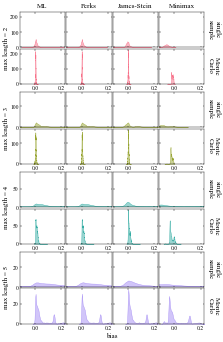

In [186]:
variables = [
    'entropy_msg_mc_ml', 'entropy_msg_mc_perks',
    'entropy_msg_mc_james-stein', 'entropy_msg_mc_minimax', 'entropy_msg_1_ml',
    'entropy_msg_1_perks', 'entropy_msg_1_james-stein', 'entropy_msg_1_minimax'
]
lengths = range(2, 6)


def plot(df_visa, df_img):
    data = pd.DataFrame({
        var: (df_visa.entropy_msg - df_visa[var]).tolist()
        + (df_img.entropy_msg - df_img[var]).tolist()
        for var in variables
    })
    data['max_len'] = df_visa.max_len.tolist() + df_img.max_len.tolist()
    data['exclude'] = (df_visa.epoch > 2).tolist() + (df_img.epoch > 2).tolist()

    w, h = 6.5, 11
    fig = plt.figure(figsize=inches(w, h), dpi=72)
    fig.supxlabel('bias', fontsize=7, y=-0.03, va='top')
    subfigs = fig.subfigures(4, 1, hspace=8 / 72, wspace=0)
    
    axes = {}

    for l, length in enumerate(lengths):
        subplots = subfigs[l].subplots(
            2, 4, sharex=False, sharey=True,
            gridspec_kw=dict(
                wspace=(2 / 72), hspace=(2 * h / w / 72),
                top=1, bottom=0, left=0, right=1
            ),
        )
        subfigs[l].supylabel(f'max length = {length}', fontsize=7, x=-0.06, ha='right')
        
        for (e, estimator), (s, samples) in product(
            enumerate(['ML', 'Perks', 'James-Stein', 'Minimax']),
            enumerate(['1', 'mc']),
        ):
            ax = axes[l, s, e] = subplots[s, e]
            sns.kdeplot(
                data=data[(~data.exclude) & (data.max_len == length)],
                x=f'entropy_msg_{samples}_{estimator.lower()}',
                color=sns.husl_palette(4)[l],
                fill=True, alpha=0.5,  linewidth=0.4,
                common_norm=False,
                bw_adjust=0.5,
                # bw_method='scott', levels=10, thresh=0.05, gridsize=200,
                # cut=3, clip=None,
                ax=ax, legend=None,
            )
            ax.tick_params(
                labelleft=(e == 0),
                labelright=False,
                labelbottom=(s == 1),
                labelsize=5.5,
            )
            if s == l == 0:
                ax.set_xlabel(estimator, visible=True, fontsize=7)
                ax.xaxis.set_label_position('top')
            else:
                ax.set_xlabel(None)
            sample_label = 'Monte\nCarlo' if samples == 'mc' else 'single\nsample'
            if e == 3:
                ax.yaxis.set_label_position('right')
                ax.set_ylabel(sample_label, fontsize=7, rotation=270, visible=True, labelpad=16)
            else:
                ax.set_ylabel(sample_label, fontsize=7, rotation=270, visible=False)
            gc.collect()

    axs = list(axes.values())
    for ax in axs[1:]:
        ax.sharex(axs[0])
    axs[0].autoscale(axis='y')

    plt.show()
    fig.savefig(
        f'../figs/fig-entropy-bias.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot(history_visa, history_img)

#### Scatter

max counts: defaultdict(<class 'int'>, {2: 14731.0, 3: 12912.0, 4: 5532.0, 5: 5092.0})
0.0 14731.0 <class 'numpy.float64'>
0.0 14731.0 <class 'numpy.float64'>
0.0 12912.0 <class 'numpy.float64'>
0.0 12912.0 <class 'numpy.float64'>
0.0 5532.0 <class 'numpy.float64'>
0.0 5532.0 <class 'numpy.float64'>
0.0 5092.0 <class 'numpy.float64'>
0.0 5092.0 <class 'numpy.float64'>


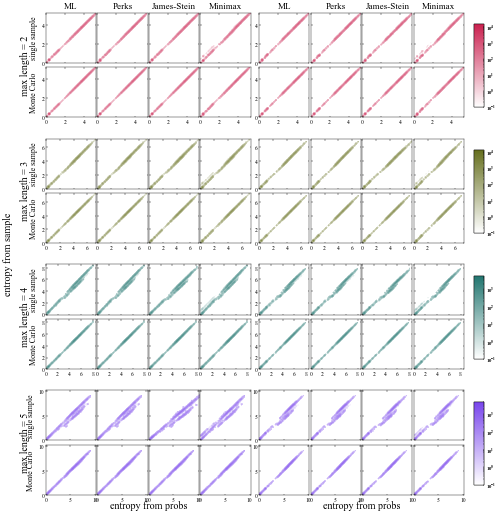

In [220]:
variables = [
    'channel', 'entropy_msg', 'max_len',
    'entropy_msg_mc_ml', 'entropy_msg_mc_perks',
    'entropy_msg_mc_james-stein', 'entropy_msg_mc_minimax', 'entropy_msg_1_ml',
    'entropy_msg_1_perks', 'entropy_msg_1_james-stein', 'entropy_msg_1_minimax',
]
lengths = range(2, 6)


def plot(df_visa, df_img, nbins=72):
    data = pd.DataFrame({
        var: (df_visa[var]).tolist() + (df_img[var]).tolist()
        for var in variables
    }) 
    data['exclude'] = (df_visa.epoch > 2).tolist() + (df_img.epoch > 2).tolist()

    w, h = 15.5, 15.5 * 84 / 76
    fig = plt.figure(figsize=inches(w, h), dpi=72)
    # fig.supylabel('entropy from sample', fontsize=10, ha='left', x=1.035, rotation=270)
    fig.supylabel('entropy from sample', fontsize=10, ha='right', x=-0.075, rotation=90)
    subfigs = fig.subfigures(4, 3, hspace=12 / 72, wspace=4 / 72 * h / w, width_ratios=[4, 4, 0.25])
    cmaps = [
        mcolors.LinearSegmentedColormap.from_list(
            'custom', ['#FFFFFF', sns.husl_palette(4, l=0.45)[l]], N=256,
        ) for l in range(4)
    ]    
    max_counts = defaultdict(int)
    for length in range(2, 6):
        _data = data[(data.max_len == length) & (~data.exclude)]
        for variable in variables[3:]:
            heatmap, _, _ = np.histogram2d(_data.entropy_msg, _data[variable], bins=nbins)
            max_counts[length] = max(max_counts[length], heatmap.max())
    print('max counts:', max_counts)
    
    axes = {}        
    for (l, length), (c, channel) in product(enumerate(lengths), enumerate(['erasure', 'deletion'])):
        subplots = subfigs[l, c].subplots(
            2, 4, sharex=False, sharey=False,
            gridspec_kw=dict(
                wspace=(2 / 72), hspace=(2 / 72),# * 76 / 84),  # (2 / 72 / 3),
                top=1, bottom=0, left=0, right=1
            ),
        )
        if c == 0:
            subfigs[l, c].supylabel(f'max length = {length}', fontsize=10, x=-0.08, ha='right')
        if l == 3:
            subfigs[l, c].supxlabel('entropy from probs', fontsize=10, y=-0.04, va='top')
            
        _data = data[(data.max_len == length) & (data.channel == channel) & (~data.exclude)]

        # max_count = 0
        # for variable in variables[3:]:
        #     heatmap, _, _ = np.histogram2d(_data.entropy_msg, _data[variable], bins=nbins)
        #     max_count = max(max_count, heatmap.max())
        # print('length', length, 'max count', max_count)

        colorbar_ax = subfigs[l, 2].subplots()
        print(0.0, max_counts[length], type(max_counts[length]))
        subfigs[l, 2].colorbar(
            matplotlib.cm.ScalarMappable(
                norm=mcolors.LogNorm(vmin=1e-1, vmax=max_counts[length]),  #Normalize
                cmap=cmaps[l],
            ),
            orientation='vertical',
            cax=colorbar_ax,
        )
        
        for (e, estimator), (s, samples) in product(
            enumerate(['ML', 'Perks', 'James-Stein', 'Minimax']),
            enumerate(['1', 'mc']),
        ):
            ax = axes[l, c, s, e] = subplots[s, e]
            variable = f'entropy_msg_{samples}_{estimator.lower()}'

            heatmap, xedges, yedges = np.histogram2d(_data.entropy_msg, _data[variable], bins=nbins)
            _max = max(xedges[-1], yedges[-1])
            ax.imshow(
                heatmap.T,
                extent=[0, _max, 0, _max],
                origin='lower',
                cmap=cmaps[l],
                interpolation='gaussian',
                # vmin=0., vmax=max_counts[length], # vmax=1.,
                # norm=mcolors.LogNorm(vmin=heatmap.min(), vmax=heatmap.max()),
                norm=mcolors.LogNorm(vmin=1, vmax=max_counts[length]),
            )
            ax.tick_params(
                labelleft=(e == 0), labelright=False,
                labelbottom=(s == 1), labelsize=5.5,
            )
            if s == l == 0:
                ax.set_xlabel(estimator, visible=True, fontsize=9)
                ax.xaxis.set_label_position('top')
            else:
                ax.set_xlabel(None)
            sample_label = 'Monte Carlo' if samples == 'mc' else 'single sample'
            if c == e == 0:
                # ax.yaxis.set_label_position('right')
                ax.set_ylabel(sample_label, fontsize=8, rotation=90, visible=True)#, labelpad=10)
            else:
                ax.set_ylabel(sample_label, visible=False)
            gc.collect()

    for l in range(len(lengths)):
        axs = [ax for key, ax in axes.items() if key[0] == l]
        for ax in axs[1:]:
            ax.sharex(axs[0])
            ax.sharey(axs[0])
        axs[0].autoscale(axis='both')
        axs[0].xaxis.set_major_locator(MaxNLocator(nbins=4, steps=[1, 2, 5], min_n_ticks=3, integer=False))
        axs[0].yaxis.set_major_locator(MaxNLocator(nbins=4, steps=[1, 2, 5], min_n_ticks=3, integer=False))

    plt.show()
    fig.savefig(
        f'../figs/fig-entropy-scatter.pdf', format='pdf', dpi='figure',
        bbox_inches='tight',
        pad_inches=0.4 / 72,
    )
    close_plot(fig)

plot(history_visa, history_img)

#### Legend

In [ ]:
max_count = 7485
